# Analysis of label transfer results and label transfer uncertainty

In this notebook we analyze the label transfer from the HLCA core to the extended HLCA. The label transfer itself was done with the python script that can be found in the /scripts/label_transfer.py script. Here, we import and analyze the results.

#### Import modules:

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import glob
import os
import sklearn.metrics
import sys
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../../scripts")
import scib_excerpts
import preprocessing

for pretty code formatting:

In [2]:
%load_ext lab_black

initiate empty dictionary to store figures in (these will be written to files at the bottom of the notebook)

In [3]:
FIGURES = dict()

#### set paths:

In [4]:
path_HLCA_ext_emb = (
    "../../data/HLCA_extended/HLCA_extended/HLCA_extended_scarches_emb.h5ad"
)
dir_label_transfer_res = "../../results/HLCA_ext_label_transfer/per_dataset"
path_label_transfer_res_out = (
    "../../results/HLCA_ext_label_transfer/transfered_labels_query_only.csv"
)
path_sheppard_counts = (
    "../../data/HLCA_extended/extension_datasets/ready/full/tsukui.h5ad"
)
path_sheppard_norm_counts = (
    "../../data/HLCA_extended/extension_datasets/ready/full/tsukui_normalized_full.h5ad"
)
path_ct_df = "../../supporting_files/celltype_structure_and_colors/manual_anns_and_leveled_anns_ordered.csv"
dir_figures = "../../results/figures"
dir_IPF_uncertainty_analysis = "../../results/fibrosis_uncertainty"

#### load files:

Dataframe with celltype information:

In [5]:
ct_df = pd.read_csv(path_ct_df, index_col=0)

In [6]:
ct_to_col_dict = {ct: col for ct, col in zip(ct_df.index, ct_df.colors)}
ct_to_col_dict["Other"] = "#949494"

Atlas embedding:

In [7]:
# scArches based embedding of extended atlas
adata_emb = sc.read_h5ad(path_HLCA_ext_emb)
# subset to query/atlas extension (i.e. not core)
adata_query_emb = adata_emb[adata_emb.obs.core_or_extension == "extension", :].copy()

Label transfer results:

In [8]:
# label transfer results
uncerts = glob.glob(f"{dir_label_transfer_res}/*uncert*")
# labs = glob.glob(f"{dir_label_transfer_res}/*label*")
results = {}
for i in uncerts:
    dataset_name = "_".join(i.split("/")[-1].split("_")[:-1])
    ds_uncerts = pd.read_csv(
        f"{dir_label_transfer_res}/{dataset_name}_uncert.csv", index_col=0
    )
    ds_labels = pd.read_csv(
        f"{dir_label_transfer_res}/{dataset_name}_labels.csv", index_col=0
    )
    # remove "_embed" suffices from indices:
    ds_uncerts.index = [x.split("_embed")[0] for x in ds_uncerts.index]
    ds_labels.index = [x.split("_embed")[0] for x in ds_labels.index]
    # store in results dictionary
    results[dataset_name] = (
        ds_uncerts,
        ds_labels,
    )

Merge the results into a single dataframe, with all annotation levels included:

In [9]:
results_df = pd.DataFrame()
for i in results.keys():
    res_tmp = pd.DataFrame()
    most_confident_level = results[i][0].iloc[:, ::-1].idxmin(axis=1)
    res_tmp["most_confident_level"] = most_confident_level
    res_tmp["most_confident_uncert"] = pd.Series(
        results[i][0].lookup(results[i][0].index, most_confident_level),
        index=results[i][0].index,
    )
    res_tmp["most_confident_label"] = pd.Series(
        results[i][1].lookup(results[i][0].index, most_confident_level),
        index=results[i][0].index,
    )
    res_tmp["transf_ann_level_5_uncert"] = results[i][0]["Level_5"]
    res_tmp["transf_ann_level_5_label"] = results[i][1]["Level_5"]
    res_tmp["transf_ann_level_4_uncert"] = results[i][0]["Level_4"]
    res_tmp["transf_ann_level_4_label"] = results[i][1]["Level_4"]
    res_tmp["transf_ann_level_3_uncert"] = results[i][0]["Level_3"]
    res_tmp["transf_ann_level_3_label"] = results[i][1]["Level_3"]
    res_tmp["transf_ann_level_2_uncert"] = results[i][0]["Level_2"]
    res_tmp["transf_ann_level_2_label"] = results[i][1]["Level_2"]
    res_tmp["transf_ann_level_1_uncert"] = results[i][0]["Level_1"]
    res_tmp["transf_ann_level_1_label"] = results[i][1]["Level_1"]
    results_df = pd.concat([results_df, res_tmp], axis=0)

/home/icb/lisa.sikkema/miniconda3/envs/HLCA_basic/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  import sys
/home/icb/lisa.sikkema/miniconda3/envs/HLCA_basic/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  # This is added back by InteractiveShellApp.init_path()


subset to query/extension cells only (2 datasets are present both in core and extension, we don't want to perform label transfer on the core):

In [10]:
results_df = results_df.loc[adata_query_emb.obs.index, :].copy()

write to file:

In [11]:
results_df.to_csv(path_label_transfer_res_out)

### To add: add label transfer results to adata_emb and store

In [12]:
# ...

# Metadata organizing/simplifying
Here, we harmonize metadata a bit and create an object containing the metadata and the uncertainties

In [13]:
query_obs = adata_query_emb.obs

In [14]:
for col in results_df.columns:
    query_obs[col] = results_df.loc[query_obs.index, col]

Add clean version of labels for level 4 and 5 (i.e. removing suffices for labels that are from lower levels, such as 3_Lymphatic EC mature (doesn't have level 4/5 finer annotations))

In [15]:
query_obs[
    "transf_ann_level_4_label_clean"
] = query_obs.transf_ann_level_4_label.str.split("_").str[-1]
query_obs[
    "transf_ann_level_5_label_clean"
] = query_obs.transf_ann_level_5_label.str.split("_").str[-1]

Clean up/simplify disease encoding:

In [16]:
sorted(query_obs.condition.unique())

['CF',
 'COPD',
 'COVID-19',
 'COVID-19 moderate',
 'COVID-19 severe',
 'Chronic rhinitis',
 'End-stage lung fibrosis, unknown etiology',
 'HP',
 'Healthy',
 'Healthy (tumor adjacent)',
 'ILD',
 'IPF',
 'Large Cell Carcinoma',
 'Lung adenocarcinoma',
 'Lymphangioleiomyomatosis',
 'Myositis-associated ILD',
 'NSIP',
 'Pleiomorphic Carcinoma',
 'Pneumonia non-COVID',
 'Sarcoidosis',
 'Squamous Cell Carcinoma',
 'Systemic sclerosis-associated ILD',
 'anti-CD3 anti-CD28 antibody stimulated']

ILD is a broad term, that includes HP, Myosytis-associated ILD, NSIP, SSc-ILD.

In [17]:
condition_simplifier = {cond: cond for cond in query_obs.condition.unique()}
condition_simplifier.update(
    {
        "COVID-19 moderate": "COVID-19",
        "COVID-19 severe": "COVID-19",
        "Healthy (tumor adjacent)": "Healthy",
        "Large Cell Carcinoma": "Carcinoma",
        "Lung adenocarcinoma": "Carcinoma",
        "Pleiomorphic Carcinoma": "Carcinoma",
        "Squamous Cell Carcinoma": "Carcinoma",
        "HP": "ILD",
        "Myositis-associated ILD": "ILD",
        "NSIP": "ILD",
        "Systemic sclerosis-associated ILD": "ILD",
    }
)

In [18]:
query_obs.condition = query_obs.condition.map(condition_simplifier)

Clean up/simplify single cell platform encoding:

In [19]:
scplatform_remapper = dict()
for scpf in query_obs.single_cell_platform.unique():
    if "3'" in scpf and "5'" not in scpf and "10X" in scpf.upper():
        scplatform_remapper[scpf] = "10X 3'"
    elif "5'" in scpf and "3'" not in scpf and "10X" in scpf.upper():
        scplatform_remapper[scpf] = "10X 5'"
    elif scpf.upper() == "SEQ-WELL":
        scplatform_remapper[scpf] = "Seq-Well"
    elif scpf.upper() == "DROP-SEQ":
        scplatform_remapper[scpf] = "Drop-Seq"
    else:
        print("No mapping for", scpf)
        scplatform_remapper[scpf] = "unknown"

In [20]:
scplatform_remapper

{"10X 3' v2": "10X 3'",
 "10X 3' v3": "10X 3'",
 'Drop-Seq': 'Drop-Seq',
 "10X 5' v1": "10X 5'",
 "10X 5'": "10X 5'",
 "10X 3'": "10X 3'",
 'Seq-Well': 'Seq-Well'}

In [21]:
query_obs["single_cell_platform_short"] = query_obs.single_cell_platform.map(
    scplatform_remapper
)

In [22]:
query_obs.single_cell_platform_short.unique()

array(["10X 3'", 'Drop-Seq', "10X 5'", 'Seq-Well'], dtype=object)

In [23]:
query_obs["single_cell_platform_and_cvn"] = [
    pf if cvn == "cells" else f"{pf} ({cvn})"
    for pf, cvn in zip(query_obs.single_cell_platform_short, query_obs.cells_or_nuclei)
]

In [24]:
query_obs.single_cell_platform_and_cvn.unique()

array(["10X 3'", 'Drop-Seq', "10X 5'", "10X 3' (nuclei)", 'Seq-Well'],
      dtype=object)

In [25]:
disease_simplification = {
    dis: "Diseased (non-COVID)" for dis in query_obs.condition.unique()
}
disease_simplification["Healthy"] = "Healthy"
disease_simplification["COVID-19"] = "COVID-19"
disease_simplification["anti-CD3 anti-CD28 antibody stimulated"] = "Other"

In [26]:
disease_simplification

{'Healthy': 'Healthy',
 'IPF': 'Diseased (non-COVID)',
 'COPD': 'Diseased (non-COVID)',
 'COVID-19': 'COVID-19',
 'CF': 'Diseased (non-COVID)',
 'Lymphangioleiomyomatosis': 'Diseased (non-COVID)',
 'ILD': 'Diseased (non-COVID)',
 'Sarcoidosis': 'Diseased (non-COVID)',
 'Carcinoma': 'Diseased (non-COVID)',
 'End-stage lung fibrosis, unknown etiology': 'Diseased (non-COVID)',
 'Chronic rhinitis': 'Diseased (non-COVID)',
 'anti-CD3 anti-CD28 antibody stimulated': 'Other',
 'Pneumonia non-COVID': 'Diseased (non-COVID)'}

In [27]:
query_obs["tissue_disease_status"] = query_obs.condition.map(disease_simplification)

Aggregate the data by either dataset+disease, dataset or sample

In [28]:
agg_dict_ds = {
    cov: "first"
    for cov in [
        "single_cell_platform_and_cvn",
        "condition",
        "cells_or_nuclei",
        "sample_type",
    ]
}
agg_dict_ds.update({"transf_ann_level_5_uncert": "mean"})
query_ds = query_obs.groupby(["dataset", "condition"]).agg(agg_dict_ds)
query_ds.dropna(axis=0, how="all", inplace=True)

In [29]:
agg_dict_d = {
    cov: "first"
    for cov in [
        "single_cell_platform_and_cvn",
        "condition",
        "cells_or_nuclei",
        "sample_type",
    ]
}
agg_dict_d.update({"transf_ann_level_5_uncert": "mean"})
query_d = query_obs.groupby(["dataset", "tissue_disease_status"]).agg(agg_dict_d)
query_d.dropna(axis=0, how="all", inplace=True)

In [30]:
agg_dict_sample = {
    cov: "first"
    for cov in [
        "single_cell_platform_and_cvn",
        "tissue_disease_status",
        "cells_or_nuclei",
        "sample_type",
        "dataset",
        "condition",
    ]
}
agg_dict_sample.update({"transf_ann_level_5_uncert": "mean"})
query_sample = query_obs.groupby(["sample"]).agg(agg_dict_sample)
query_sample.dropna(axis=0, how="all", inplace=True)

In [31]:
query_ds_ipf = query_ds.loc[
    query_ds.index.get_level_values(1) == "IPF", :
]  # query_ipf.groupby(['dataset', 'condition']).first()[['single_cell_platform', 'disease', 'cells_or_nuclei']]

Create a dataframe of all cells for which we have harmonized labels, and to only datasets that were not also partly in the core:

In [32]:
core_studies = set(
    adata_emb.obs.loc[adata_emb.obs.core_or_extension == "core", "study"]
)

In [33]:
query_anno = query_obs.loc[
    [
        not_none and not_nan and not_in_core
        for not_none, not_nan, not_in_core in zip(
            ~query_obs.original_ann_level_5.isin(["None", "nan"]),
            ~pd.isnull(query_obs.original_ann_level_5),
            ~query_obs.study.isin(core_studies),
        )
    ],
    :,
].copy()

In [34]:
query_anno["original_ann_level"] = query_anno.original_ann_level_5.str.split("_").str[0]
# level 5 annotations had no prefix:
query_anno.original_ann_level = [
    lev if lev in ["1", "2", "3", "4"] else "5" for lev in query_anno.original_ann_level
]

subset label transfer results to annotated cells, and to only datasets that were not also partly in the core:

In [35]:
res_anno = results_df.loc[query_anno.index, :].copy()

Now get the transfered annotations at the level of the original annotations, so that we will be able to compare them later:

In [36]:
query_anno["predicted_corresponding"] = [
    res_anno.loc[idx, f"transf_ann_level_{orig_ann_level}_label"]
    for idx, orig_ann_level in zip(query_anno.index, query_anno.original_ann_level)
]

Remove prefixes specifying level (e.g. 3_AT2) to match with original labels:

In [37]:
def remove_numeric_prefix(ct_name):
    ct_name_split = ct_name.split("_")
    if ct_name_split[0] in ["1", "2", "3", "4", "5"]:
        return "_".join(ct_name_split[1:])
    else:
        return ct_name

In [38]:
query_anno.predicted_corresponding = [
    remove_numeric_prefix(ct_old) for ct_old in query_anno.predicted_corresponding
]

Look up matching uncertainty levels:

In [39]:
query_anno["predicted_corresponding_uncert"] = [
    res_anno.loc[idx, f"transf_ann_level_{orig_ann_level}_uncert"]
    for idx, orig_ann_level in zip(query_anno.index, query_anno.original_ann_level)
]

Remove prefixes from original annotations:

In [40]:
query_anno["original_ann_level_highest"] = [
    remove_numeric_prefix(ct_old) for ct_old in query_anno.original_ann_level_5
]

In [41]:
query_anno["original_ann_level"] = query_anno.original_ann_level.astype(int)

Now check if transfered labels matched original labels:

In [42]:
query_anno["correct_prediction"] = (
    query_anno.original_ann_level_highest == query_anno.predicted_corresponding
)

Subset to cells that had an original annotation at a higher level than level 1:

In [43]:
query_anno_2_and_up = query_anno.query("original_ann_level > 1")

## Thresholding label mapping correctness

Include only cells with level 3 or 4 annotations, as these are informative annotations without being extremely detailed (transfered level 5 annotations will more often)

In [44]:
query_anno_2_4 = query_anno_2_and_up.query("original_ann_level<5")

In [45]:
query_anno_3_4 = query_anno_2_4.query("original_ann_level>2")

check which datasets are included:

In [46]:
sorted(query_anno_3_4.dataset.unique())

['Duong_lungMAP_unpubl',
 'Eils_2020',
 'Kaminski_2020',
 'Meyer_2021_3prime',
 'Meyer_2021_5prime',
 'Sheppard_2020',
 'Sun_2020_batch1',
 'Sun_2020_batch2',
 'Sun_2020_batch3',
 'Sun_2020_batch4',
 'Thienpont_2018_10Xv1',
 'Thienpont_2018_10Xv2']

generate roc curve:

In [47]:
roc = sklearn.metrics.roc_curve(
    query_anno_3_4.correct_prediction,
    query_anno_3_4.predicted_corresponding_uncert * -1,
    drop_intermediate=False,
)

In [48]:
unc_threshold = 0.20

In [49]:
unc_threshold_cutoff_df = pd.DataFrame(roc, index=["FPR", "TPR", "threshold"]).T.query(
    f"threshold<-{unc_threshold}"
)

In [50]:
unc_threshold_cutoff_df.head(5)

FPR       TPR  threshold
22139  0.495077  0.878650       -0.2
22140  0.495086  0.878667       -0.2
22141  0.495104  0.878684       -0.2
22142  0.495131  0.878692       -0.2
22143  0.495177  0.878704       -0.2

In [51]:
FPR_cutoff = unc_threshold_cutoff_df["FPR"].values[0]
TPR_cutoff = unc_threshold_cutoff_df["TPR"].values[0]

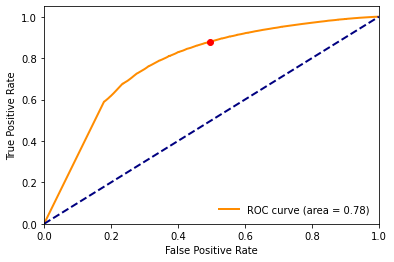

In [52]:
fig = plt.figure()
lw = 2
plt.plot(
    roc[0],
    roc[1],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % sklearn.metrics.auc(roc[0], roc[1]),
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", frameon=False)
plt.plot(FPR_cutoff, TPR_cutoff, "ro")
plt.show()
FIGURES["ED20_ROC_curve_label_transfer"] = fig

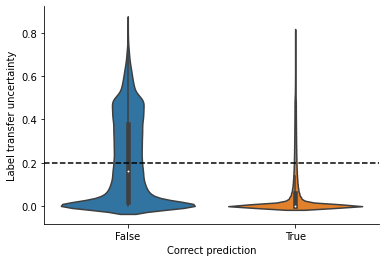

In [53]:
graph = sns.violinplot(
    x=query_anno_2_and_up.correct_prediction,
    y=query_anno_2_and_up.predicted_corresponding_uncert,
    scale="width",
)
graph.axhline(unc_threshold, linestyle="dashed", color="black")
graph.set(xlabel="Correct prediction", ylabel="Label transfer uncertainty")
sns.despine()

How many datasets are below the mean uncertainty threshold?

In [54]:
(
    query_obs.groupby("dataset")["transf_ann_level_5_uncert"].mean() < unc_threshold
).value_counts()

True     27
False    10
Name: transf_ann_level_5_uncert, dtype: int64

## Effect of donor age on uncertainty

In [55]:
sample_age_uncert_info = query_obs.groupby("sample").agg(
    {
        "age": "first",
        "transf_ann_level_5_uncert": "mean",
        "tissue_disease_status": "first",
        "study": "first",
    }
)

In [56]:
sample_age_uncert_info = sample_age_uncert_info.loc[
    ~pd.isnull(sample_age_uncert_info.age), :
].copy()

In [57]:
sample_age_uncert_info_clean = sample_age_uncert_info.loc[
    [dis == "Healthy" for dis in sample_age_uncert_info.tissue_disease_status], :
].copy()

In [58]:
sample_age_uncert_info_clean.study = (
    sample_age_uncert_info_clean.study.cat.remove_unused_categories()
)

In [59]:
sample_age_uncert_info_clean["age_bin"] = np.digitize(
    sample_age_uncert_info_clean.age, np.arange(0, 90, 10)
)

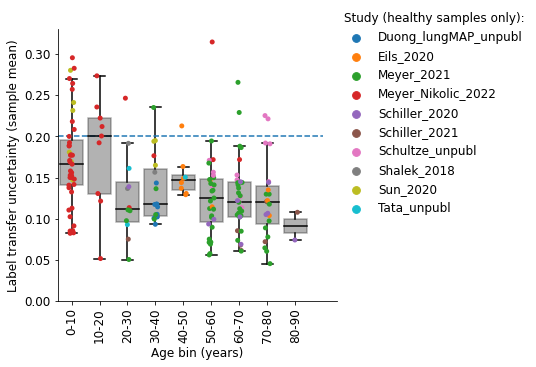

In [60]:
fz = 12
with plt.rc_context(
    {
        "figure.figsize": (5, 5),
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots()
    sns.stripplot(
        data=sample_age_uncert_info_clean,
        x="age_bin",
        y="transf_ann_level_5_uncert",
        hue=sample_age_uncert_info_clean.study,
        ax=ax,
    )
    sns.boxplot(
        data=sample_age_uncert_info_clean,
        x="age_bin",
        y="transf_ann_level_5_uncert",
        color="black",
        fliersize=0,
        ax=ax,
        boxprops=dict(alpha=0.3),
    )
    ax.set_xticklabels(
        [
            f"{low}-{high}"
            for low, high in zip(np.arange(0, 90, 10), np.arange(10, 100, 10))
        ],
        rotation=90,
    )
    ax.set_ylim((0, 0.33))
    ax.hlines(xmin=-0.5, xmax=9, y=unc_threshold, linestyles="--")
    ax.set_xlabel("Age bin (years)")
    ax.set_ylabel("Label transfer uncertainty (sample mean)")
    leg = plt.legend(
        loc=(1.01, 0.3), frameon=False, title="Study (healthy samples only):"
    )
    leg._legend_box.align = "left"
    # plt.tight_layout()
    plt.show()
    plt.close()
    # store
    FIGURES["6c_label_tr_uncert_by_age"] = fig

Plot a corresponding plot showing the frequency of different age groups in the *core*:

In [61]:
core_obs = adata_emb.obs.loc[adata_emb.obs.core_or_extension == "core", :].copy()
core_obs.subject_ID = core_obs.subject_ID.cat.remove_unused_categories()
core_ages = core_obs.groupby("subject_ID").agg({"age": "first"})

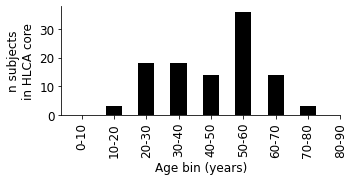

In [62]:
fz = 12
with plt.rc_context(
    {
        "figure.figsize": (5, 2),
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots()
    ax.hist(core_ages.age, bins=np.arange(0, 90, 10), rwidth=0.5, color="black")
    plt.xticks(
        ticks=np.arange(5, 95, 10),
        labels=[
            f"{low}-{high}"
            for low, high in zip(np.arange(0, 90, 10), np.arange(10, 100, 10))
        ],
        rotation=90,
    )
    ax.set_xlabel("Age bin (years)")
    ax.set_ylabel("n subjects\nin HLCA core")
    # plt.tight_layout()
    plt.show()
    plt.close()
    # # store
    FIGURES["6c_label_tr_uncert_by_age_matched_core_barplot"] = fig

## Disease cell states and uncertainty

Here we'll take a close look at one of the disease datasets for which we also had cell type annotations, i.e. the Sheppard dataset:

Import the raw counts and normalize data using SCRAN (commented out here as it was run before and takes a while):

In [63]:
# sheppard_raw_counts = sc.read(path_sheppard_counts)

In [64]:
# sheppard_raw_counts.obs.index = (
#     sheppard_raw_counts.obs.index + "_tsukui"
# )  # add suffix to match with query adata

In [65]:
# sc.pp.filter_genes(sheppard_raw_counts, min_cells=1)

SCRAN normalization:

In [66]:
# sheppard_norm_counts = scib_excerpts.SCRAN_normalize(sheppard_raw_counts, log_transform=True)

In [67]:
# sheppard_norm_counts.write(path_sheppard_norm_counts)

Read in normalized, log-transformed counts:

In [112]:
sheppard_norm_counts = sc.read(path_sheppard_norm_counts)

Copy obs from query_obs:

In [113]:
sheppard_norm_counts.obs = query_obs.loc[sheppard_norm_counts.obs.index, :].copy()

Copy embedding from adata_query_emb:

In [114]:
sheppard_norm_counts.obsm["X_scanvi_emb"] = adata_query_emb[
    sheppard_norm_counts.obs.index, :
].X

In [115]:
sheppard_stroma = sheppard_norm_counts[
    sheppard_norm_counts.obs.original_ann_level_5 == "1_Stroma"
]

In [116]:
sheppard_macro = sheppard_norm_counts[
    sheppard_norm_counts.obs.original_ann_level_5 == "3_Macrophages"
]

Remove scleroderma ILD samples, we only want to include healthy and ipf for simplicity:

In [117]:
sheppard_stroma = sheppard_stroma[sheppard_stroma.obs.condition != "ILD"]
sheppard_macro = sheppard_macro[sheppard_macro.obs.condition != "ILD"]

Remove cell types (based on label transfer) that have fewer than min_n_cells_sheppard cells from object:

In [118]:
min_n_cells_sheppard = 10

In [119]:
sheppard_stroma = sheppard_stroma[
    sheppard_stroma.obs.transf_ann_level_5_label.isin(
        sheppard_stroma.obs.transf_ann_level_5_label.value_counts()[
            sheppard_stroma.obs.transf_ann_level_5_label.value_counts()
            >= min_n_cells_sheppard
        ].index
    )
]

In [120]:
sheppard_macro = sheppard_macro[
    sheppard_macro.obs.transf_ann_level_5_label.isin(
        sheppard_macro.obs.transf_ann_level_5_label.value_counts()[
            sheppard_macro.obs.transf_ann_level_5_label.value_counts()
            >= min_n_cells_sheppard
        ].index
    )
]

Now calculate umap based on scArches-mapping embedding:

In [121]:
sc.pp.neighbors(sheppard_stroma, use_rep="X_scanvi_emb")

/home/icb/lisa.sikkema/miniconda3/envs/HLCA_basic/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """Entry point for launching an IPython kernel.


In [122]:
sc.tl.umap(sheppard_stroma)

In [123]:
sc.pp.neighbors(sheppard_macro, use_rep="X_scanvi_emb")

/home/icb/lisa.sikkema/miniconda3/envs/HLCA_basic/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """Entry point for launching an IPython kernel.


In [124]:
sc.tl.umap(sheppard_macro)

Shuffle order of adatas to make sure plotting order is randomized:

In [125]:
sheppard_stroma = sheppard_stroma[
    sheppard_stroma.obs.sample(frac=1, replace=False).index, :
].copy()
sheppard_macro = sheppard_macro[
    sheppard_macro.obs.sample(frac=1, replace=False).index, :
].copy()

Remove prefixes (1_, 2_ etc.) and set labels from other compartments/lev2 anns to "Other", same for cts with fewer than 10 cells:

In [126]:
# stroma
sheppard_stroma.obs[
    "transf_ann_level_5_label_clean"
] = sheppard_stroma.obs.transf_ann_level_5_label.str.split("_").str[-1]
sheppard_stroma.obs.loc[
    sheppard_stroma.obs.transf_ann_level_1_label != "Stroma",
    "transf_ann_level_5_label_clean",
] = "Other"
sheppard_ct_counts_stroma = (
    sheppard_stroma.obs.transf_ann_level_5_label_clean.value_counts()
)
# set cts with fewer than 10 cells to Other
sheppard_rare_cts_stroma = sheppard_ct_counts_stroma.loc[
    sheppard_ct_counts_stroma < 10
].index
sheppard_stroma.obs.loc[
    sheppard_stroma.obs.transf_ann_level_5_label_clean.isin(sheppard_rare_cts_stroma),
    "transf_ann_level_5_label_clean",
] = "Other"
# macro:
sheppard_macro.obs[
    "transf_ann_level_5_label_clean"
] = sheppard_macro.obs.transf_ann_level_5_label.str.split("_").str[-1]
sheppard_macro.obs.loc[
    sheppard_macro.obs.transf_ann_level_2_label != "Myeloid",
    "transf_ann_level_5_label_clean",
] = "Other"
sheppard_ct_counts_macro = (
    sheppard_macro.obs.transf_ann_level_5_label_clean.value_counts()
)
# set cts with fewer than 10 cells to Other
sheppard_rare_cts_macro = sheppard_ct_counts_macro.loc[
    sheppard_ct_counts_macro < 10
].index
sheppard_macro.obs.loc[
    sheppard_macro.obs.transf_ann_level_5_label_clean.isin(sheppard_rare_cts_macro),
    "transf_ann_level_5_label_clean",
] = "Other"

In [127]:
sc.set_figure_params(figsize=(4, 4))

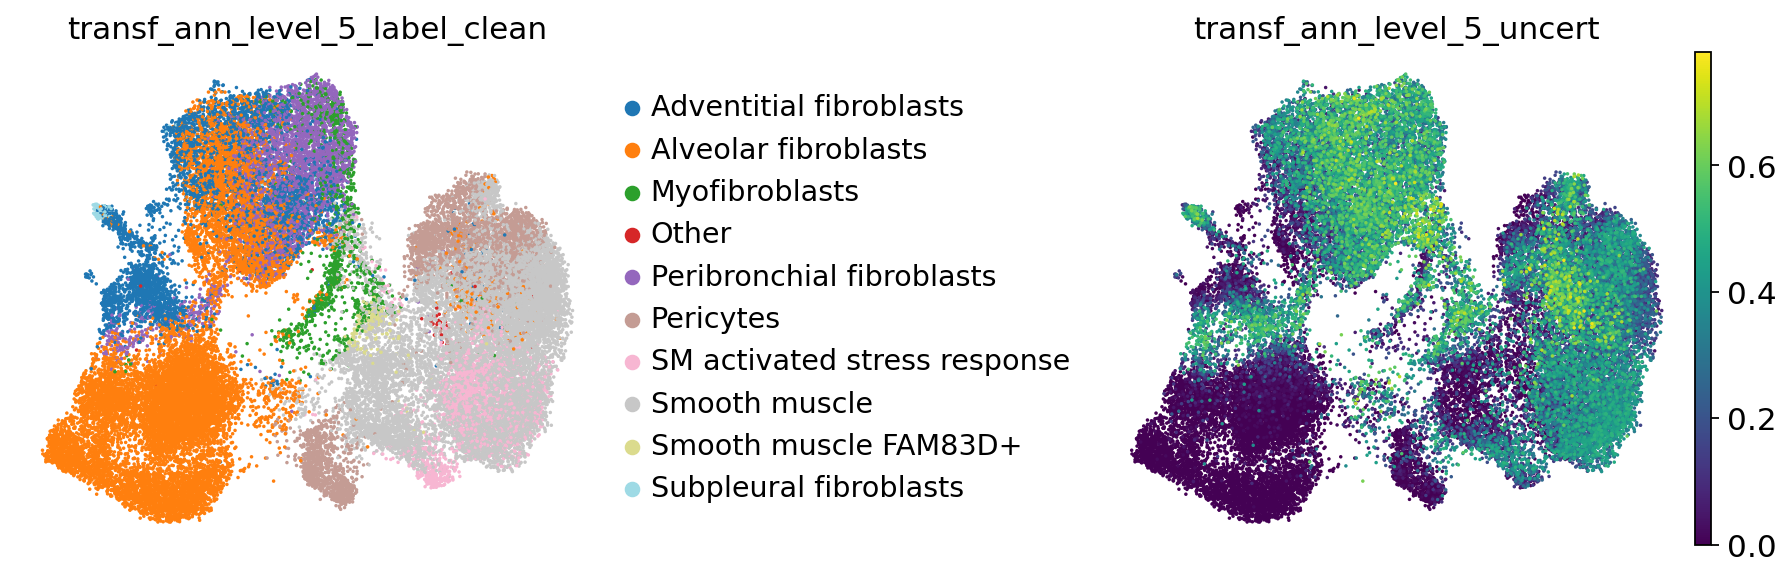

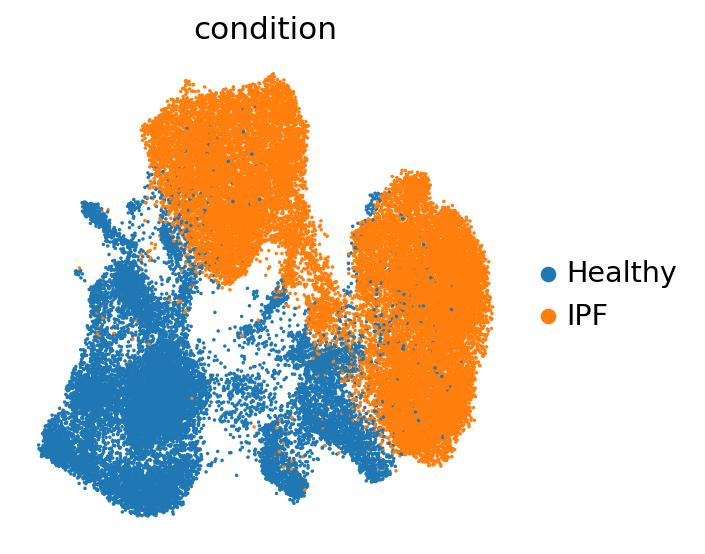

In [128]:
FIGURES["ED22a_IPF_stroma_transfered_labs_and_uncert"] = sc.pl.umap(
    sheppard_stroma,
    color=["transf_ann_level_5_label_clean", "transf_ann_level_5_uncert"],
    size=10,
    frameon=False,
    palette="tab20",
    wspace=0.7,
    return_fig=True,
)
FIGURES["ED22a_IPF_stroma_condition"] = sc.pl.umap(
    sheppard_stroma,
    color=["condition"],
    palette={"Healthy": "tab:blue", "IPF": "tab:orange"},
    size=10,
    frameon=False,
    sort_order=False,
    return_fig=True,
)

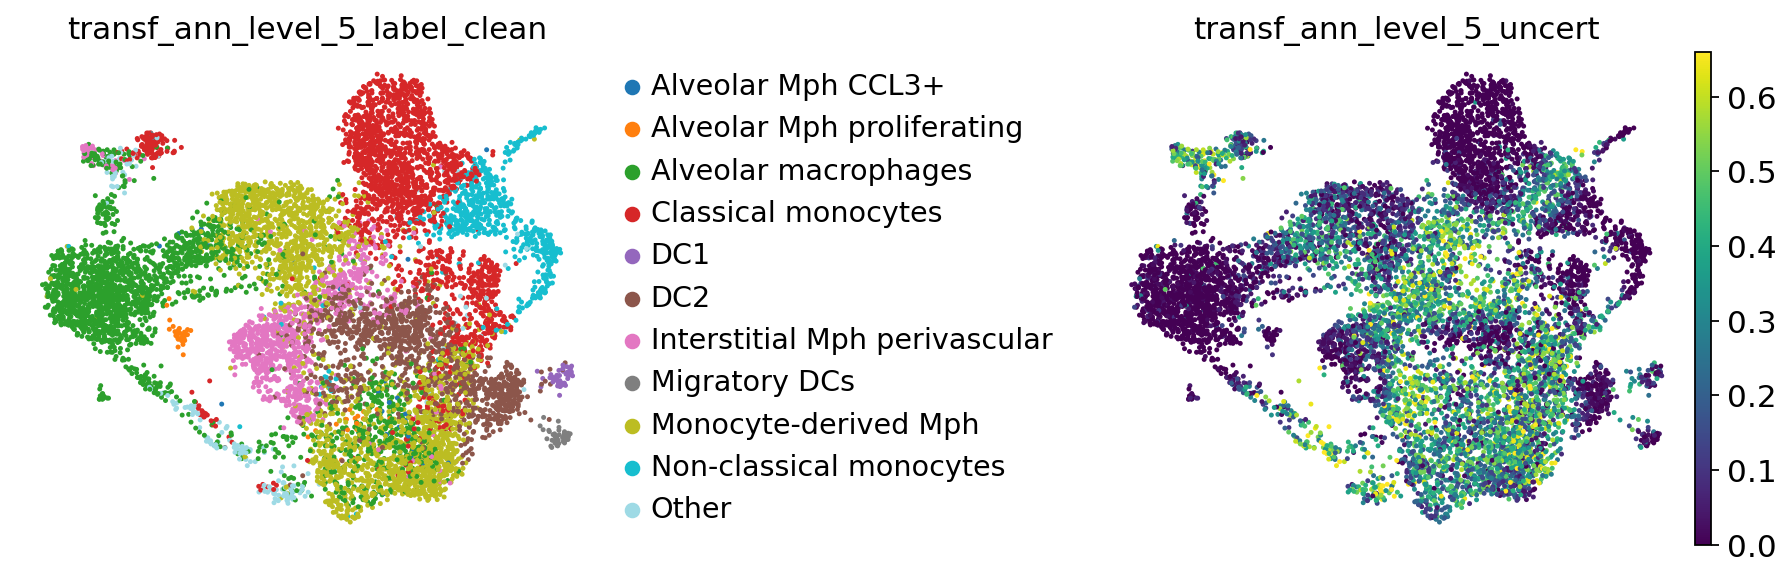

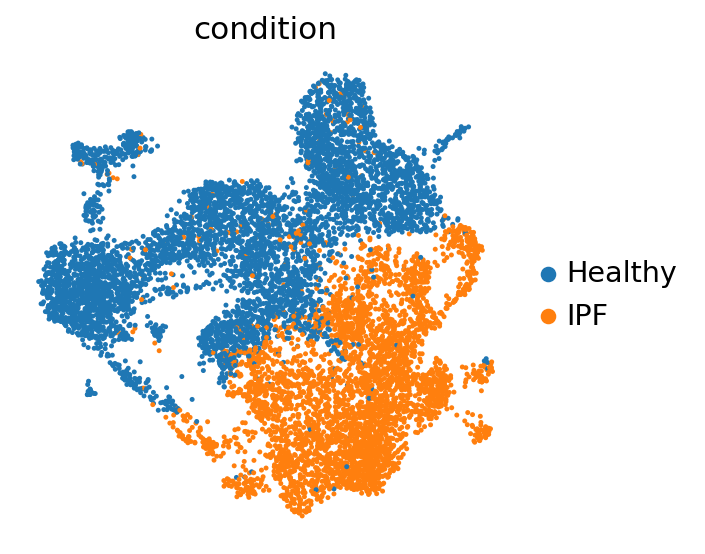

In [129]:
FIGURES["ED22b_IPF_macro_transfered_labs_and_uncert"] = sc.pl.umap(
    sheppard_macro,
    color=["transf_ann_level_5_label_clean", "transf_ann_level_5_uncert"],
    size=20,
    frameon=False,
    sort_order=False,
    vmax="p99",
    wspace=0.7,
    palette="tab20",
    return_fig=True,
)
FIGURES["ED22b_IPF_macro_condition"] = sc.pl.umap(
    sheppard_macro,
    color="condition",
    size=20,
    palette={"Healthy": "tab:blue", "IPF": "tab:orange"},
    frameon=False,
    sort_order=False,
    return_fig=True,
)

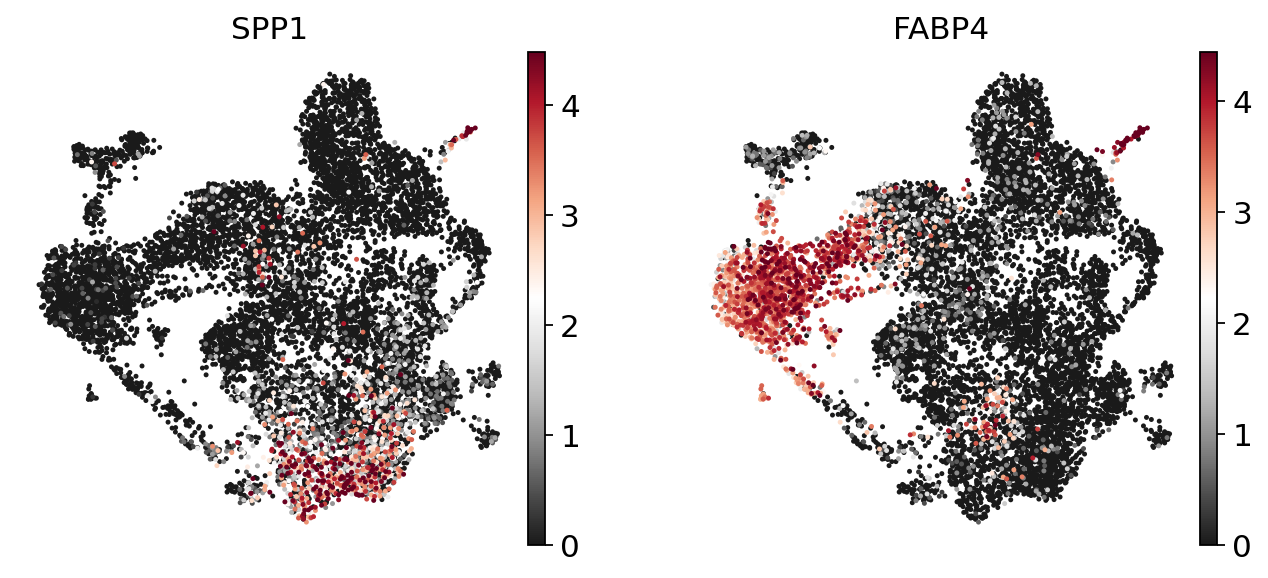

In [130]:
FIGURES["ED22c_IPF_macro_SPP1_FABP4_expression"] = sc.pl.umap(
    sheppard_macro,
    color=["SPP1", "FABP4"],
    size=20,
    frameon=False,
    cmap="RdGy_r",
    vmax="p99",
    return_fig=True,
)

## Effect of disease on uncertainty
Here, we analyse the uncertainty within cell types between conditions. We focus on IPF so remove scleroderma = ILD

In [131]:
sheppard_filt = sheppard_norm_counts[
    sheppard_norm_counts.obs.condition != "ILD", :
].copy()

Calculate level 4 uncertainties for healthy and ipf samples separately:

In [132]:
uncerts_ts_group = (
    sheppard_filt.obs.groupby(["transf_ann_level_4_label_clean", "condition"])
    .agg({"transf_ann_level_4_uncert": "mean", "condition": "count"})
    .unstack()
).droplevel(axis=1, level=0)

In [133]:
uncerts_ts_group.columns = ["Healthy_unc", "IPF_unc", "Healthy_ncells", "IPF_ncells"]

Calculate differences between IPF and healthy and order by largest diff (unc higher in IPF):

In [134]:
diff_uncerts = uncerts_ts_group.IPF_unc - uncerts_ts_group.Healthy_unc
# drop cell types that aren't present in both
diff_uncerts_filt = diff_uncerts.loc[
    [
        (suff_h and suff_i)
        for suff_h, suff_i in zip(
            uncerts_ts_group.Healthy_ncells > 10, uncerts_ts_group.IPF_ncells > 10
        )
    ]
].copy()

In [135]:
order_violin = diff_uncerts_filt.sort_values(ascending=False).index

In [136]:
plt.rcParams["figure.dpi"] = 200

In [137]:
plt.rcParams["figure.figsize"] = (12, 3)

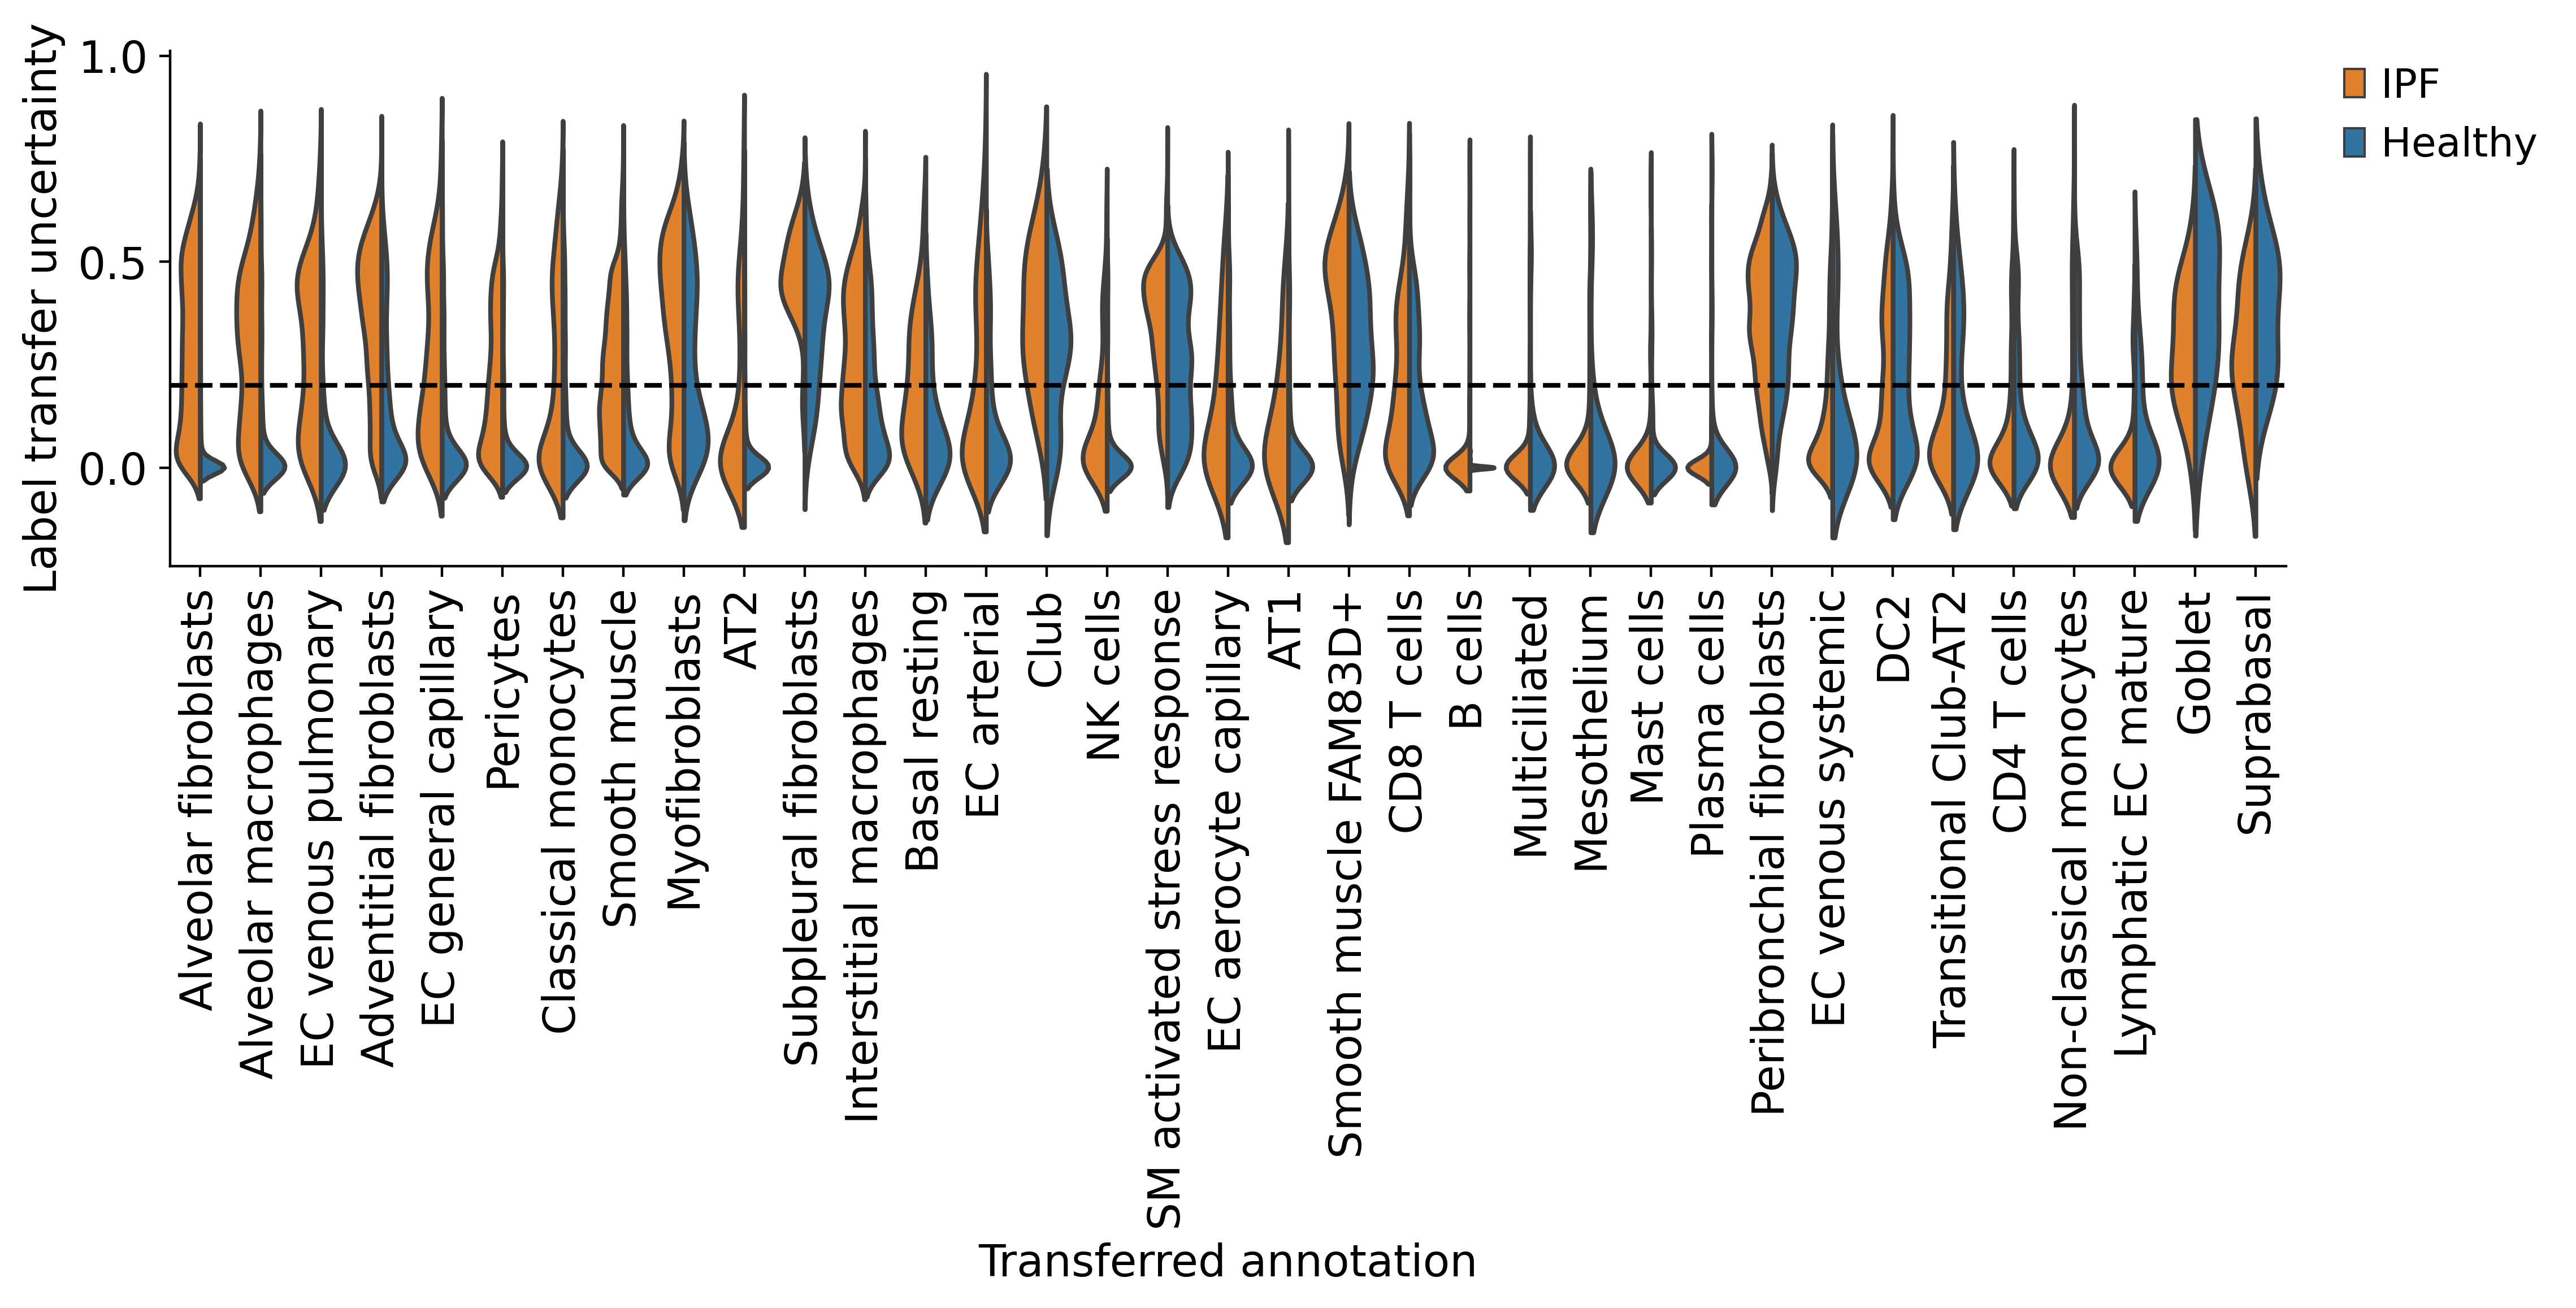

In [138]:
fig, ax = plt.subplots()
# graph =
sns.violinplot(
    x=sheppard_filt.obs.transf_ann_level_4_label_clean,
    y=sheppard_filt.obs.transf_ann_level_4_uncert,
    hue=sheppard_filt.obs.condition,
    split=True,
    inner=None,
    scale="width",
    order=order_violin,
    ax=ax,
    palette={"Healthy": "tab:blue", "IPF": "tab:orange"},
)
ax.axhline(unc_threshold, linestyle="dashed", color="black")
ax.set(xlabel="Transferred annotation", ylabel="Label transfer uncertainty")
ax.tick_params("x", rotation=90)
ax.grid(False)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0, frameon=False)
sns.despine()
FIGURES["6d_IPF_vs_Healthy_ct_uncerts"] = fig

## Can we identify diseased cell states by uncertainty
Here, we compare differentially expressed genes between conditions vs between high and low uncertainty cells.
For this, we use diffxpy

In [139]:
sheppard_alv_fibro = sheppard_filt[
    sheppard_filt.obs.transf_ann_level_4_label == "Alveolar fibroblasts"
].copy()

In [140]:
sheppard_alv_macro = sheppard_filt[
    sheppard_filt.obs.transf_ann_level_4_label == "Alveolar macrophages"
].copy()

Perform differential expression analysis, and filter out genes that are highly expressed in the outgroup:

In [141]:
sc.tl.rank_genes_groups(
    sheppard_alv_fibro,
    groupby="condition",
    n_genes=100,
    key_added="dea_condition",
    method="wilcoxon",
)

In [142]:
sc.tl.filter_rank_genes_groups(
    sheppard_alv_fibro, key_added="dea_condition_filtered", key="dea_condition"
)

In [143]:
sc.tl.rank_genes_groups(
    sheppard_alv_macro,
    groupby="condition",
    n_genes=100,
    key_added="dea_condition",
    method="wilcoxon",
)

In [144]:
sc.tl.filter_rank_genes_groups(
    sheppard_alv_macro, key_added="dea_condition_filtered", key="dea_condition"
)

Plot results:

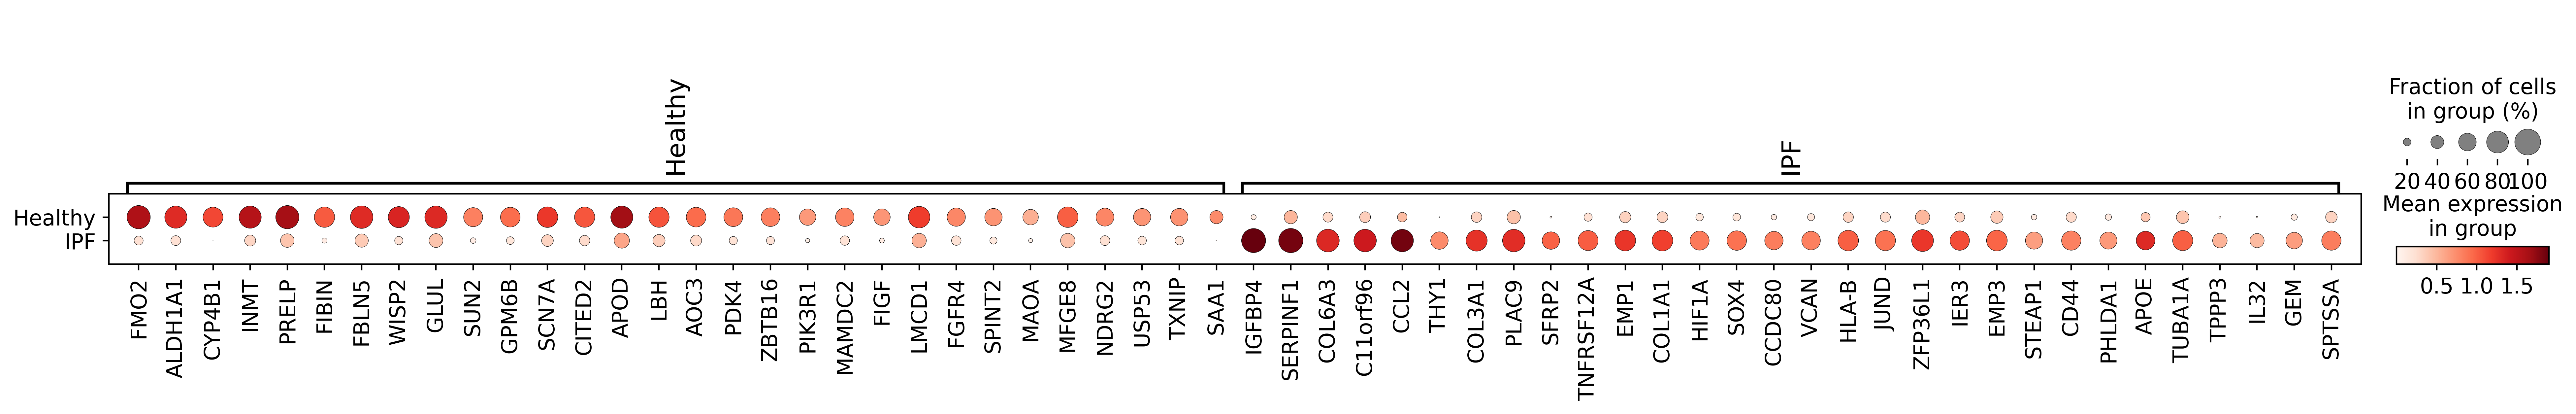

In [145]:
sc.pl.rank_genes_groups_dotplot(
    sheppard_alv_fibro, key="dea_condition_filtered", n_genes=30
)

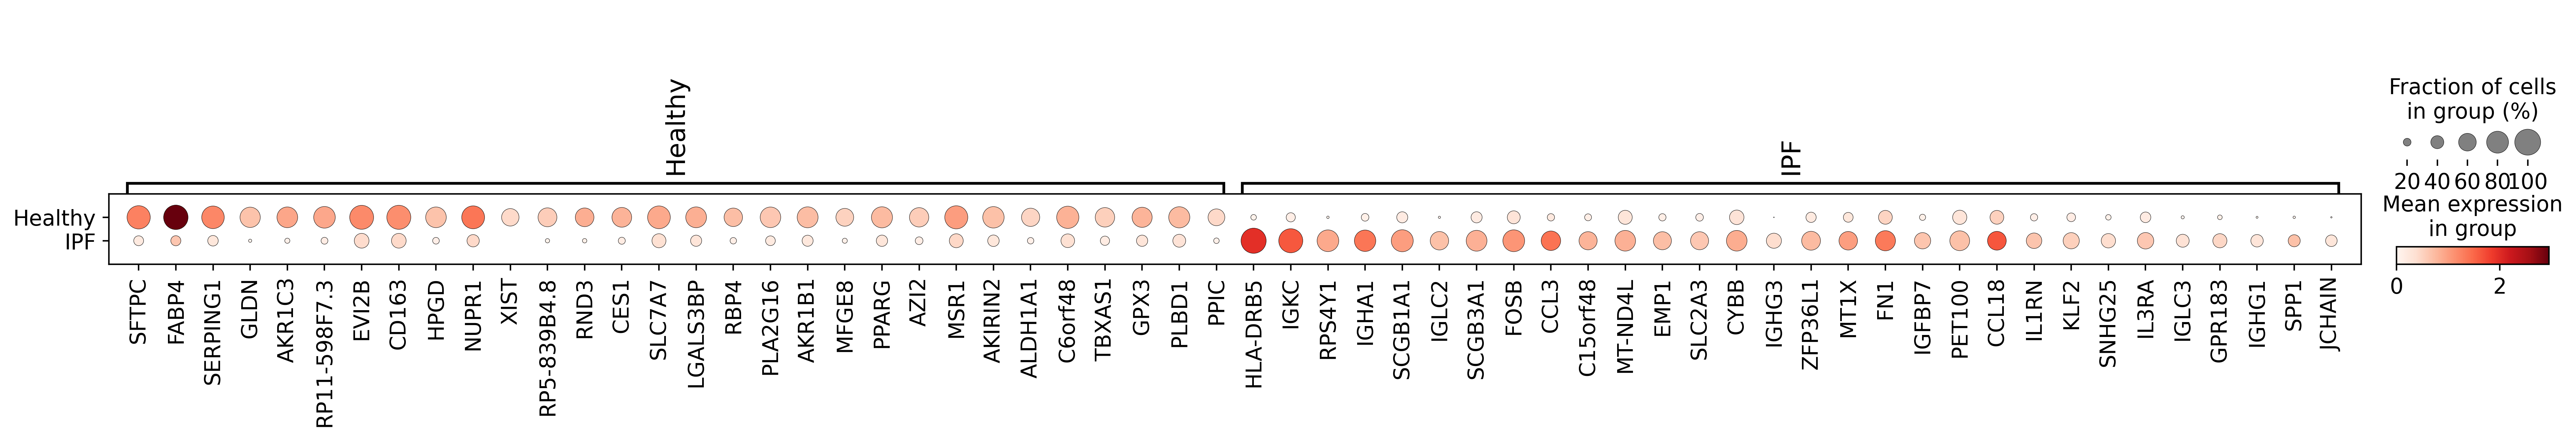

In [146]:
sc.pl.rank_genes_groups_dotplot(
    sheppard_alv_macro,
    key="dea_condition_filtered",
    n_genes=30,
)

Split uncertainty levels into low and high:

In [147]:
sheppard_alv_fibro.obs["unc_lev4_bin"] = "Low"
sheppard_alv_fibro.obs.loc[
    sheppard_alv_fibro.obs.transf_ann_level_4_uncert > unc_threshold, "unc_lev4_bin"
] = "High"
sheppard_alv_macro.obs["unc_lev4_bin"] = "Low"
sheppard_alv_macro.obs.loc[
    sheppard_alv_macro.obs.transf_ann_level_4_uncert > unc_threshold, "unc_lev4_bin"
] = "High"

Keep only cells that have either very low uncertainty (below the thresholdclculated earlier) or very high uncertainty (>0.4) for an easier determination of differences correlating with uncertainty:

In [148]:
sheppard_alv_fibro_extr_unc_only = sheppard_alv_fibro[
    [
        (unc < unc_threshold or unc > 0.4) and cond == "IPF"
        for unc, cond in zip(
            sheppard_alv_fibro.obs.transf_ann_level_4_uncert,
            sheppard_alv_fibro.obs.condition,
        )
    ],
    :,
].copy()

In [149]:
sheppard_alv_macro_extr_unc_only = sheppard_alv_macro[
    [
        (unc < unc_threshold or unc > 0.4) and cond == "IPF"
        for unc, cond in zip(
            sheppard_alv_macro.obs.transf_ann_level_4_uncert,
            sheppard_alv_macro.obs.condition,
        )
    ],
    :,
].copy()

Now calculate differenitally expressed genes between the low and high uncertainty group:

In [150]:
sc.tl.rank_genes_groups(
    sheppard_alv_fibro_extr_unc_only,
    groupby="unc_lev4_bin",
    # n_genes=100,
    key_added="dea_unc",
    method="wilcoxon",
)

In [151]:
sc.tl.rank_genes_groups(
    sheppard_alv_macro_extr_unc_only,
    groupby="unc_lev4_bin",
    # n_genes=100,
    key_added="dea_unc",
    method="wilcoxon",
)

Plot results. You'll see that the differences are subtle, but nonetheless many known fibrosis-related genes are highlighted:

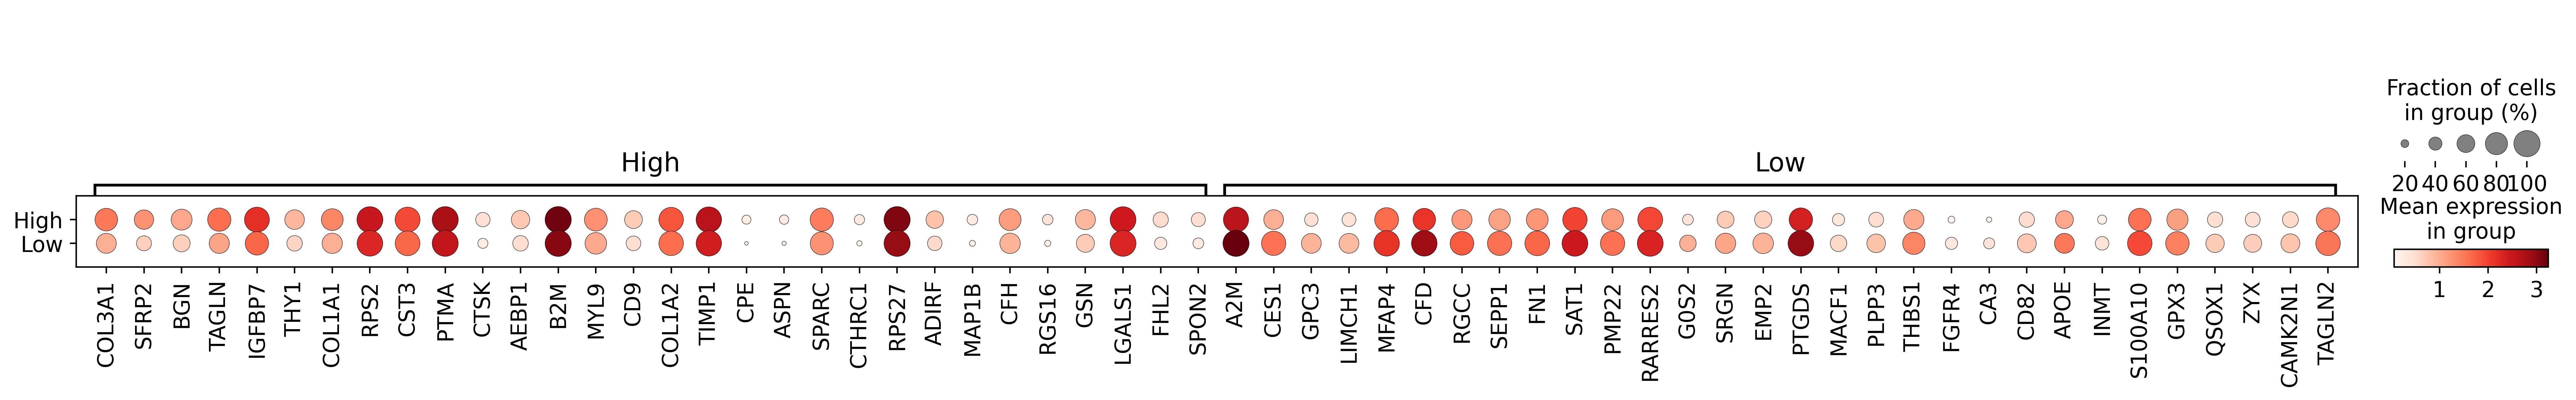

In [152]:
sc.pl.rank_genes_groups_dotplot(
    sheppard_alv_fibro_extr_unc_only,
    key="dea_unc",
    n_genes=30,
)

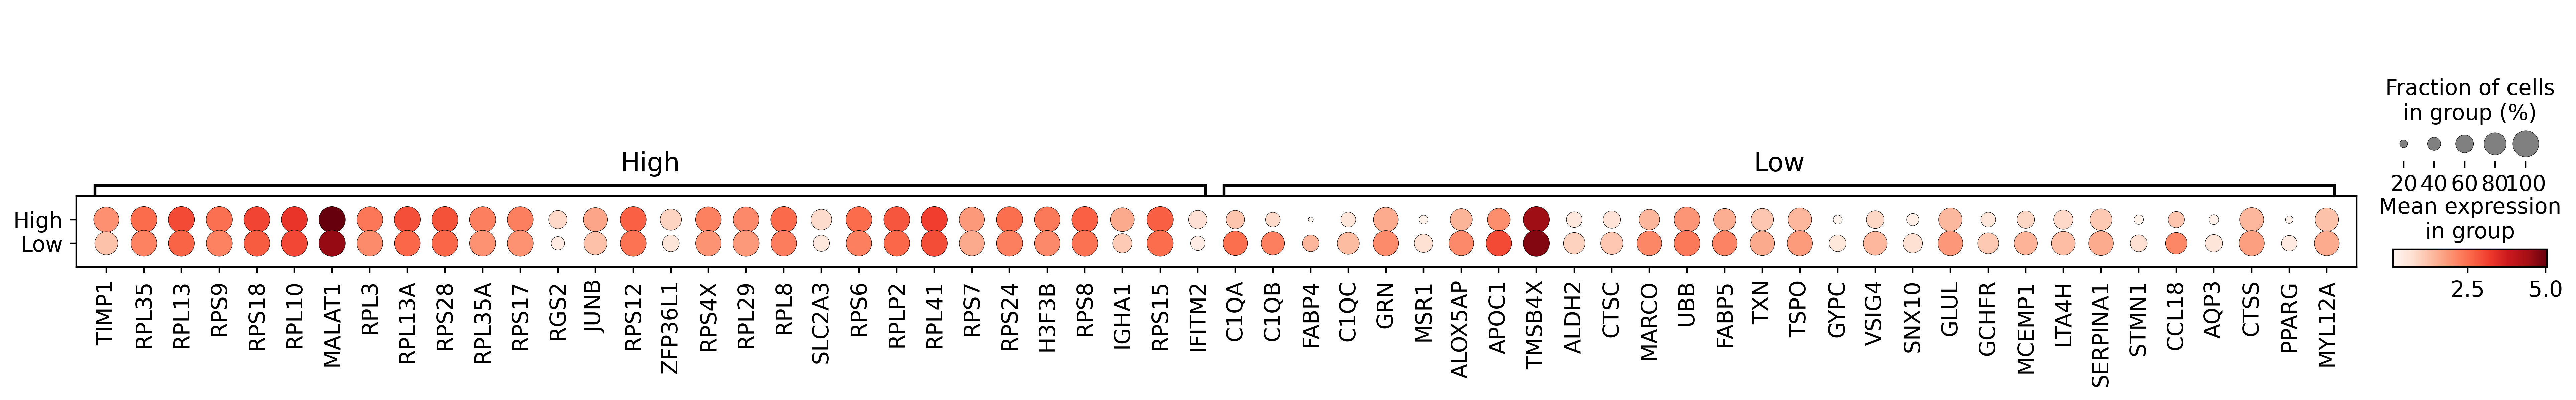

In [153]:
sc.pl.rank_genes_groups_dotplot(
    sheppard_alv_macro_extr_unc_only,
    key="dea_unc",
    n_genes=30,
)

Store differentially expressed genes (degs) in a dataframe, calcualte mean expression in the high uncertainty group, and filter based on adj. p-value and mean aexpression, then sort based on log-fold change:

In [154]:
fib_unc_degs = sc.get.rank_genes_groups_df(
    sheppard_alv_fibro_extr_unc_only, group="High", key="dea_unc"
)
fib_unc_degs.index = fib_unc_degs.names
fib_unc_degs.drop(columns="names", inplace=True)
# calculate mean expression in high unc group
fib_unc_degs["mean_count"] = np.array(
    sheppard_alv_fibro_extr_unc_only[
        sheppard_alv_fibro_extr_unc_only.obs.unc_lev4_bin == "High", fib_unc_degs.index
    ]
    .X.mean(axis=0)
    .T
)
# filter out insignificant genes and filter out genes with mean expression
# below 0.1, then sort by logfoldchange
fib_unc_degs_filt = (
    fib_unc_degs.loc[
        [
            adj_p < 0.05 and me > 0.1
            for adj_p, me in zip(fib_unc_degs.pvals_adj, fib_unc_degs.mean_count)
        ],
        :,
    ]
    .copy()
    .sort_values(by="logfoldchanges", ascending=False)
).head(20)

In [159]:
macr_unc_degs = sc.get.rank_genes_groups_df(
    sheppard_alv_macro_extr_unc_only, group="High", key="dea_unc"
)
macr_unc_degs.index = macr_unc_degs.names
macr_unc_degs.drop(columns="names", inplace=True)
# calculate mean expression in high unc group
macr_unc_degs["mean_count"] = np.array(
    sheppard_alv_macro_extr_unc_only[
        sheppard_alv_macro_extr_unc_only.obs.unc_lev4_bin == "High", macr_unc_degs.index
    ]
    .X.mean(axis=0)
    .T
)
# filter out insignificant genes and filter out genes with mean expression
# below 0.1, then sort by logfoldchange
macr_unc_degs_filt = (
    macr_unc_degs.loc[
        [
            adj_p < 0.05 and me > 0.1
            for adj_p, me in zip(macr_unc_degs.pvals_adj, macr_unc_degs.mean_count)
        ],
        :,
    ]
    .copy()
    .sort_values(by="logfoldchanges", ascending=False)
).head(20)

Show resulting top 20, we'll use these as a basis for the gene-set-scoring below:

In [160]:
fib_unc_degs_filt

scores  logfoldchanges         pvals     pvals_adj  mean_count
names                                                                     
SFRP4     5.082712        2.104406  3.720846e-07  6.950027e-05    0.204307
CPE       7.565014        2.009385  3.878234e-14  2.019963e-11    0.245591
ASPN      7.496635        1.997388  6.547709e-14  3.284040e-11    0.285145
TINAGL1   4.929175        1.985640  8.257750e-07  1.491019e-04    0.171637
TGFBI     3.549828        1.946661  3.854827e-04  3.838387e-02    0.105975
IGFBP2    5.624125        1.800432  1.864507e-08  4.072445e-06    0.237125
COMP      5.916688        1.770588  3.284889e-09  8.808705e-07    0.242379
INHBA     3.658702        1.694582  2.534961e-04  2.640650e-02    0.128114
RGS16     7.001045        1.570020  2.540606e-12  1.042572e-09    0.414718
CTHRC1    7.478432        1.546668  7.521460e-14  3.637700e-11    0.274672
SFRP2    13.581712        1.472785  5.141089e-42  1.160344e-38    1.260327
CRABP2    4.172336        1.410399  3.014924e-05  4.057864e-03    0.126486
MAP1B     7.215099        1.366349  5.389485e-13  2.366691e-10    0.277799
NOTCH3    3.702520        1.359121  2.134683e-04  2.276211e-02    0.136212
PDLIM4    6.267527        1.323279  3.668283e-10  1.155253e-07    0.290736
EPS8      4.712773        1.282960  2.443679e-06  4.110844e-04    0.167617
CNN1      4.099657        1.151729  4.137629e-05  5.286016e-03    0.235219
CHN1      5.194751        1.101286  2.049942e-07  3.925458e-05    0.240465
POSTN     5.738829        1.096847  9.533362e-09  2.368822e-06    0.298829
TPBG      3.538669        1.069971  4.021496e-04  3.975117e-02    0.115081

In [161]:
macr_unc_degs_filt

scores  logfoldchanges         pvals     pvals_adj  mean_count
names                                                                     
FCGR2B    4.053535        1.585388  5.044937e-05  1.177906e-02    0.430187
RGS1      4.150505        1.504580  3.317424e-05  8.723216e-03    0.544156
RGS2      5.341414        1.439251  9.222429e-08  6.092202e-05    0.836200
DDIT4     3.760606        1.418857  1.695022e-04  3.210348e-02    0.370336
TIMP1     8.007071        1.363791  1.174730e-15  9.387741e-12    1.975679
CREM      3.930303        1.331918  8.483887e-05  1.757716e-02    0.454479
AREG      3.717172        1.187175  2.014655e-04  3.686819e-02    0.845613
C15orf48  4.536869        1.156498  5.709563e-06  1.982536e-03    0.994124
GPR183    3.877778        1.153903  1.054149e-04  2.114858e-02    0.664967
IFITM2    4.724242        1.144394  2.309748e-06  8.810874e-04    0.691088
NR4A2     4.115656        1.087008  3.860788e-05  9.917912e-03    0.639949
IER3      4.001010        1.065548  6.307267e-05  1.435513e-02    0.692916
DUSP2     3.662121        1.015856  2.501354e-04  4.399135e-02    0.587718
ZFP36L1   5.194445        1.011007  2.053321e-07  1.169324e-04    0.943952
CCL3      4.036869        1.010543  5.416937e-05  1.253951e-02    1.579375
IGHA1     4.745960        1.000584  2.075201e-06  8.247866e-04    1.607103
IFITM3    4.654545        0.969038  3.246962e-06  1.178304e-03    1.100000
SLC2A3    5.082828        0.959274  3.718559e-07  1.936797e-04    0.778843
JUNB      5.288889        0.809722  1.230616e-07  7.751165e-05    1.675832
IGLC2     4.234344        0.805033  2.292204e-05  6.534953e-03    0.828332

Here, we use the scanpy `score_genes` function to see if we can identify diseased cells based on uncertainty alone.

In [162]:
sc.tl.score_genes(
    sheppard_alv_fibro, fib_unc_degs_filt.index, score_name="disease_score_unc_based"
)

In [163]:
sc.tl.score_genes(
    sheppard_alv_fibro_extr_unc_only,
    fib_unc_degs_filt.index,
    score_name="disease_score_unc_based",
)

In [164]:
sc.tl.score_genes(
    sheppard_alv_macro, macr_unc_degs_filt.index, score_name="disease_score_unc_based"
)

In [165]:
sc.tl.score_genes(
    sheppard_alv_macro_extr_unc_only,
    macr_unc_degs_filt.index,
    score_name="disease_score_unc_based",
)

Now plot some summary figures showing differences in "disease score" based on disease status or uncertainty levels:

In [166]:
sns.set_style("ticks")

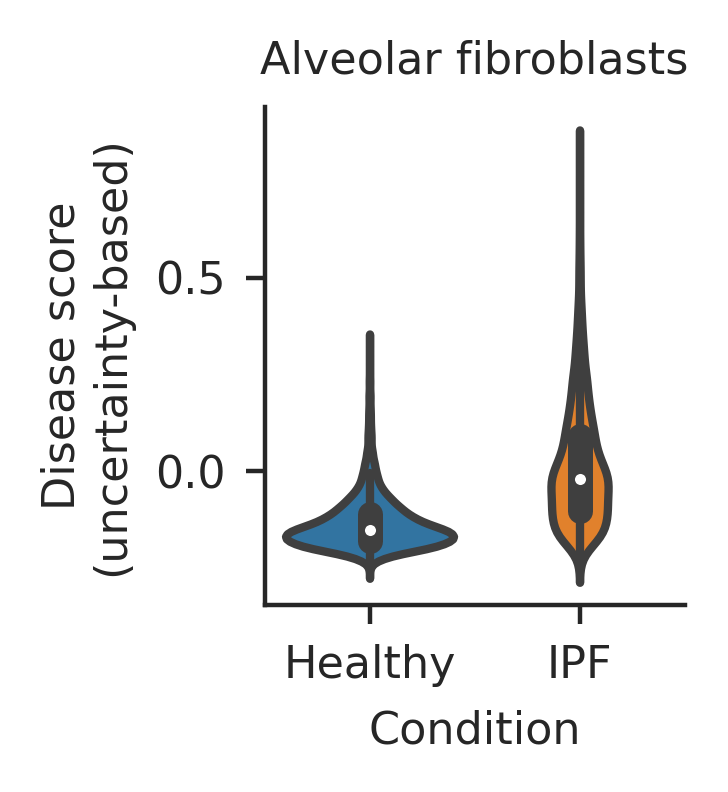

In [167]:
fz = 8
with plt.rc_context(
    {
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots(figsize=(2, 2))
    sns.violinplot(
        y=sheppard_alv_fibro.obs.disease_score_unc_based,
        x=sheppard_alv_fibro.obs.condition,
        ax=ax,
    )
    sns.despine()
    ax.set_xlabel("Condition")
    ax.set_ylabel("Disease score\n(uncertainty-based)")
    ax.set_title("Alveolar fibroblasts", fontsize=fz)
    plt.tight_layout()
    plt.show()

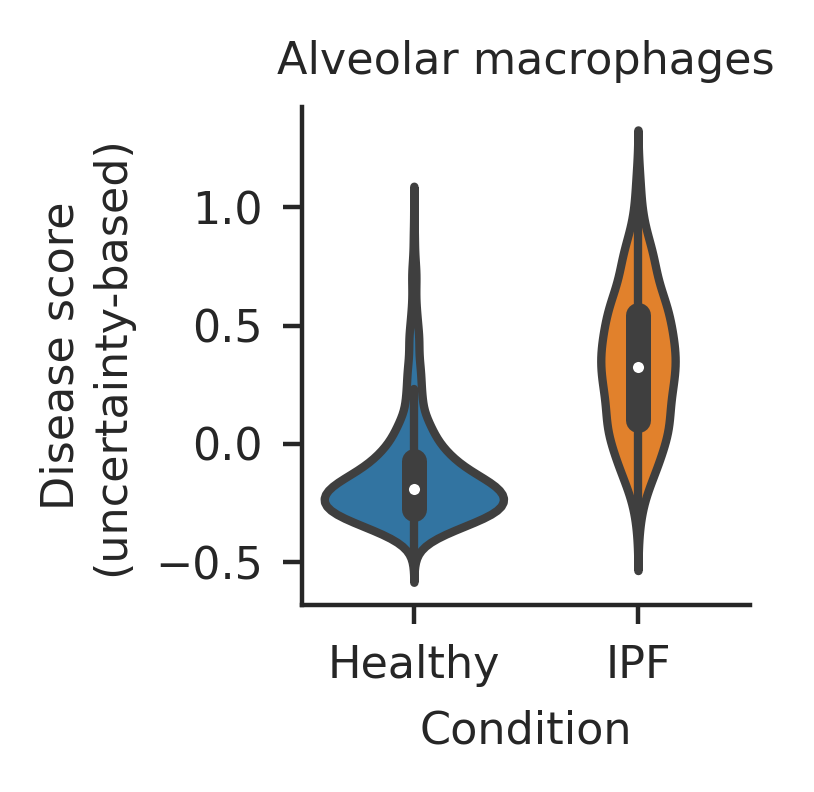

In [168]:
fz = 8
with plt.rc_context(
    {
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots(figsize=(2, 2))
    sns.violinplot(
        y=sheppard_alv_macro.obs.disease_score_unc_based,
        x=sheppard_alv_macro.obs.condition,
        ax=ax,
    )
    sns.despine()
    ax.set_xlabel("Condition")
    ax.set_ylabel("Disease score\n(uncertainty-based)")
    ax.set_title("Alveolar macrophages", fontsize=fz)
    plt.tight_layout()
    plt.show()

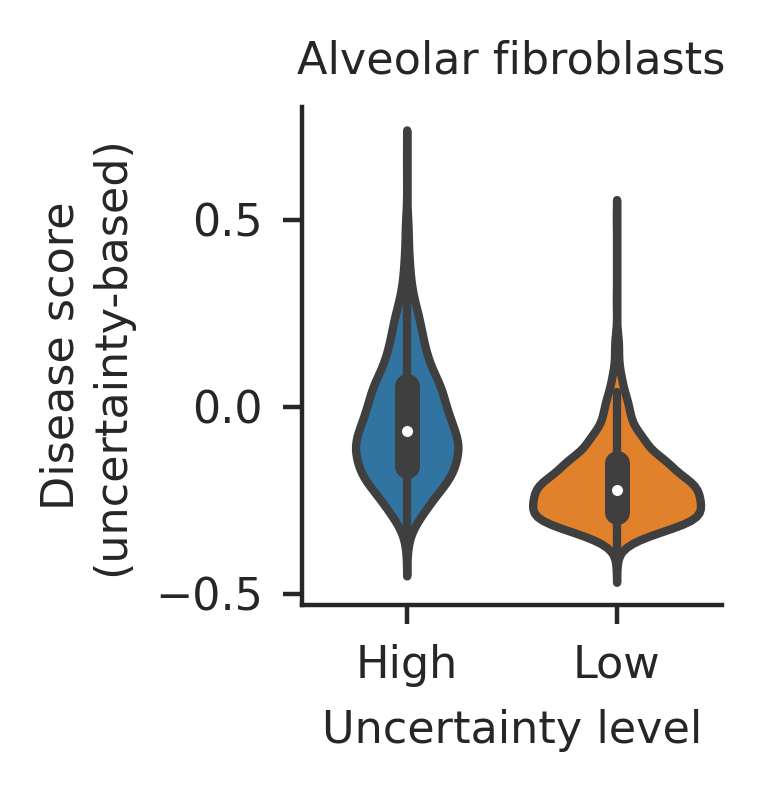

In [169]:
fz = 8
with plt.rc_context(
    {
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots(figsize=(2, 2))
    sns.violinplot(
        x=sheppard_alv_fibro_extr_unc_only.obs.unc_lev4_bin,
        y=sheppard_alv_fibro_extr_unc_only.obs.disease_score_unc_based,
        ax=ax,
    )
    sns.despine()
    ax.set_xlabel("Uncertainty level")
    ax.set_ylabel("Disease score\n(uncertainty-based)")
    ax.set_title("Alveolar fibroblasts", fontsize=fz)
    plt.tight_layout()

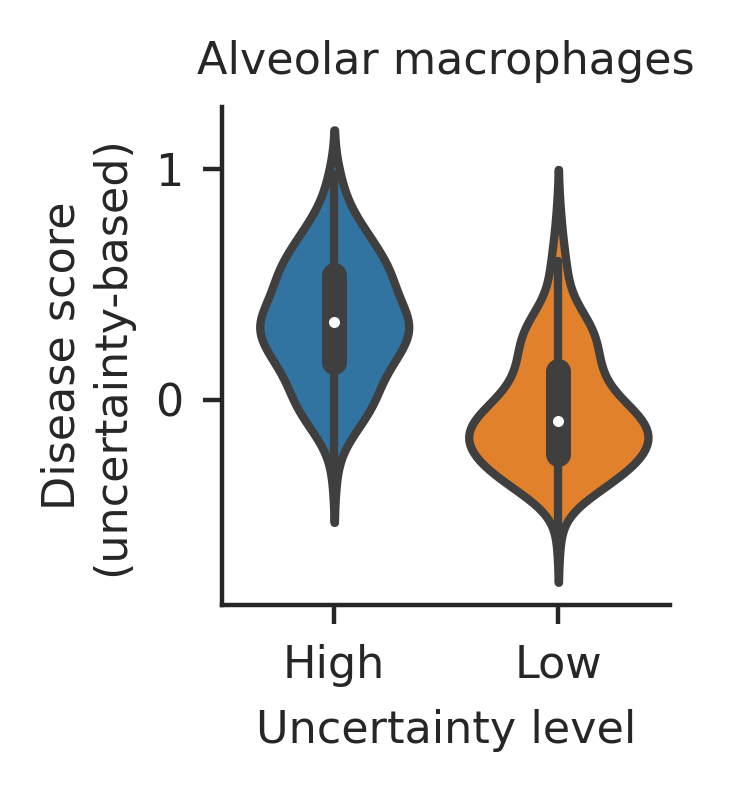

In [170]:
fz = 8
with plt.rc_context(
    {
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots(figsize=(2, 2))
    sns.violinplot(
        x=sheppard_alv_macro_extr_unc_only.obs.unc_lev4_bin,
        y=sheppard_alv_macro_extr_unc_only.obs.disease_score_unc_based,
        ax=ax,
    )
    sns.despine()
    ax.set_xlabel("Uncertainty level")
    ax.set_ylabel("Disease score\n(uncertainty-based)")
    ax.set_title("Alveolar macrophages", fontsize=fz)
    plt.tight_layout()

To compare healthy (all) to low versus high uncertainty IPF, subset to all healthies + low or high uncert ipf cells, and name accordingly:

In [171]:
sheppard_alv_fibro_extr_unc_fibs = sheppard_alv_fibro[
    [
        unc < unc_threshold or unc > 0.4 or cond == "Healthy"
        for unc, cond in zip(
            sheppard_alv_fibro.obs.transf_ann_level_4_uncert,
            sheppard_alv_fibro.obs.condition,
        )
    ],
    :,
].copy()
sheppard_alv_fibro_extr_unc_fibs.obs[
    "cond_uncert_groups"
] = "Other"  # should all be replaced in the following lines:
sheppard_alv_fibro_extr_unc_fibs.obs.loc[
    sheppard_alv_fibro_extr_unc_fibs.obs.transf_ann_level_4_uncert < unc_threshold,
    "cond_uncert_groups",
] = "IPF (low uncert.)"
sheppard_alv_fibro_extr_unc_fibs.obs.loc[
    sheppard_alv_fibro_extr_unc_fibs.obs.transf_ann_level_4_uncert > 0.4,
    "cond_uncert_groups",
] = "IPF (high uncert.)"
sheppard_alv_fibro_extr_unc_fibs.obs.loc[
    sheppard_alv_fibro_extr_unc_fibs.obs.condition == "Healthy", "cond_uncert_groups"
] = "Healthy"
sheppard_alv_fibro_extr_unc_fibs.obs.cond_uncert_groups = pd.Categorical(
    sheppard_alv_fibro_extr_unc_fibs.obs.cond_uncert_groups,
    categories=["Healthy", "IPF (low uncert.)", "IPF (high uncert.)"],
)

In [172]:
sheppard_alv_macro_extr_unc_fibs = sheppard_alv_macro[
    [
        unc < unc_threshold or unc > 0.4 or cond == "Healthy"
        for unc, cond in zip(
            sheppard_alv_macro.obs.transf_ann_level_4_uncert,
            sheppard_alv_macro.obs.condition,
        )
    ],
    :,
].copy()
sheppard_alv_macro_extr_unc_fibs.obs[
    "cond_uncert_groups"
] = "Other"  # should all be replaced in the following lines:
sheppard_alv_macro_extr_unc_fibs.obs.loc[
    sheppard_alv_macro_extr_unc_fibs.obs.transf_ann_level_4_uncert < unc_threshold,
    "cond_uncert_groups",
] = "IPF (low uncert.)"
sheppard_alv_macro_extr_unc_fibs.obs.loc[
    sheppard_alv_macro_extr_unc_fibs.obs.transf_ann_level_4_uncert > 0.4,
    "cond_uncert_groups",
] = "IPF (high uncert.)"
sheppard_alv_macro_extr_unc_fibs.obs.loc[
    sheppard_alv_macro_extr_unc_fibs.obs.condition == "Healthy", "cond_uncert_groups"
] = "Healthy"
sheppard_alv_macro_extr_unc_fibs.obs.cond_uncert_groups = pd.Categorical(
    sheppard_alv_macro_extr_unc_fibs.obs.cond_uncert_groups,
    categories=["Healthy", "IPF (low uncert.)", "IPF (high uncert.)"],
)

Now plot disease score boxplots of healthy, IPF low uncert and IPF high uncert:

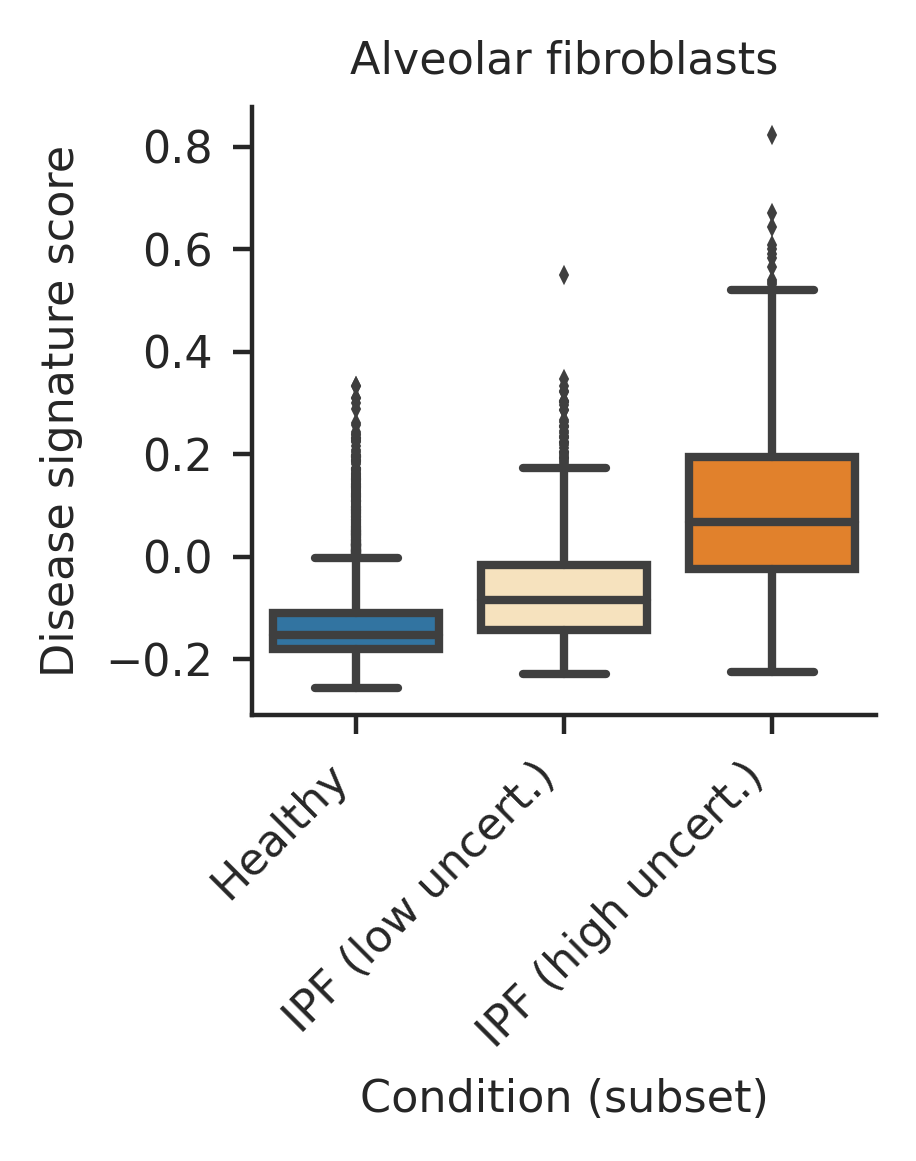

In [173]:
fz = 8
with plt.rc_context(
    {
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots(figsize=(2, 2))
    sns.boxplot(
        y=sheppard_alv_fibro_extr_unc_fibs.obs.disease_score_unc_based,
        x=sheppard_alv_fibro_extr_unc_fibs.obs.cond_uncert_groups,
        ax=ax,
        palette={
            "Healthy": "tab:blue",
            "IPF (low uncert.)": "moccasin",
            "IPF (high uncert.)": "tab:orange",
        },
        fliersize=1,
    )
    sns.despine()
    ax.set_xlabel("Condition (subset)")
    ax.set_ylabel("Disease signature score")
    ax.set_title("Alveolar fibroblasts", fontsize=fz)
    plt.xticks(rotation=45, horizontalalignment="right")
    plt.show()
    plt.close()
    FIGURES["6e_disease_score_alv_fibs_by_condition"] = fig

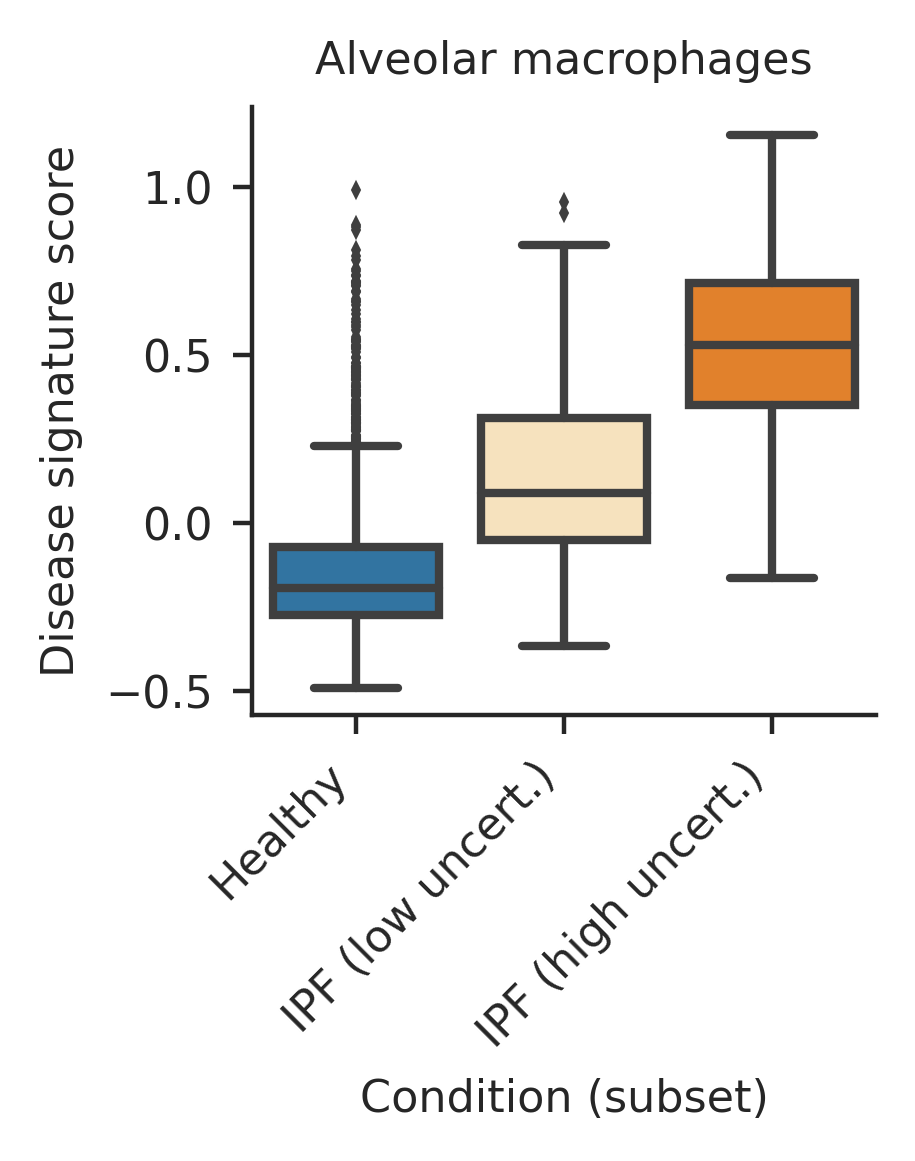

In [174]:
fz = 8
with plt.rc_context(
    {
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots(figsize=(2, 2))
    sns.boxplot(
        y=sheppard_alv_macro_extr_unc_fibs.obs.disease_score_unc_based,
        x=sheppard_alv_macro_extr_unc_fibs.obs.cond_uncert_groups,
        ax=ax,
        palette={
            "Healthy": "tab:blue",
            "IPF (low uncert.)": "moccasin",
            "IPF (high uncert.)": "tab:orange",
        },
        fliersize=1,
    )
    sns.despine()
    ax.set_xlabel("Condition (subset)")
    ax.set_ylabel("Disease signature score")
    ax.set_title("Alveolar macrophages", fontsize=fz)
    plt.xticks(rotation=45, horizontalalignment="right")
    plt.show()
    plt.close()
    FIGURES["6e_disease_score_alv_macs_by_condition"] = fig

## Which covariates influence uncertainty the most?
Here, we evaluate how covariates (Disease, Sequencing tech, Sample type, sn vs sc) have an impact on the mean uncertainty per sample or dataset+condition.

In [175]:
dataset_condition_info = (
    query_obs.groupby(["dataset", "condition"])
    .agg(
        {"condition": "first", "dataset": "first", "transf_ann_level_5_uncert": "mean"}
    )
    .dropna(axis=0, how="any")
).droplevel(level=1, axis=0)

In [176]:
conditions_to_include = dataset_condition_info.condition.value_counts()[
    dataset_condition_info.condition.value_counts() > 2
].index

In [177]:
dataset_condition_info = dataset_condition_info[
    dataset_condition_info.condition.isin(conditions_to_include)
]

In [178]:
condition_order = (
    dataset_condition_info.groupby("condition")
    .agg({"transf_ann_level_5_uncert": "mean"})
    .sort_values(by="transf_ann_level_5_uncert")
    .index
)

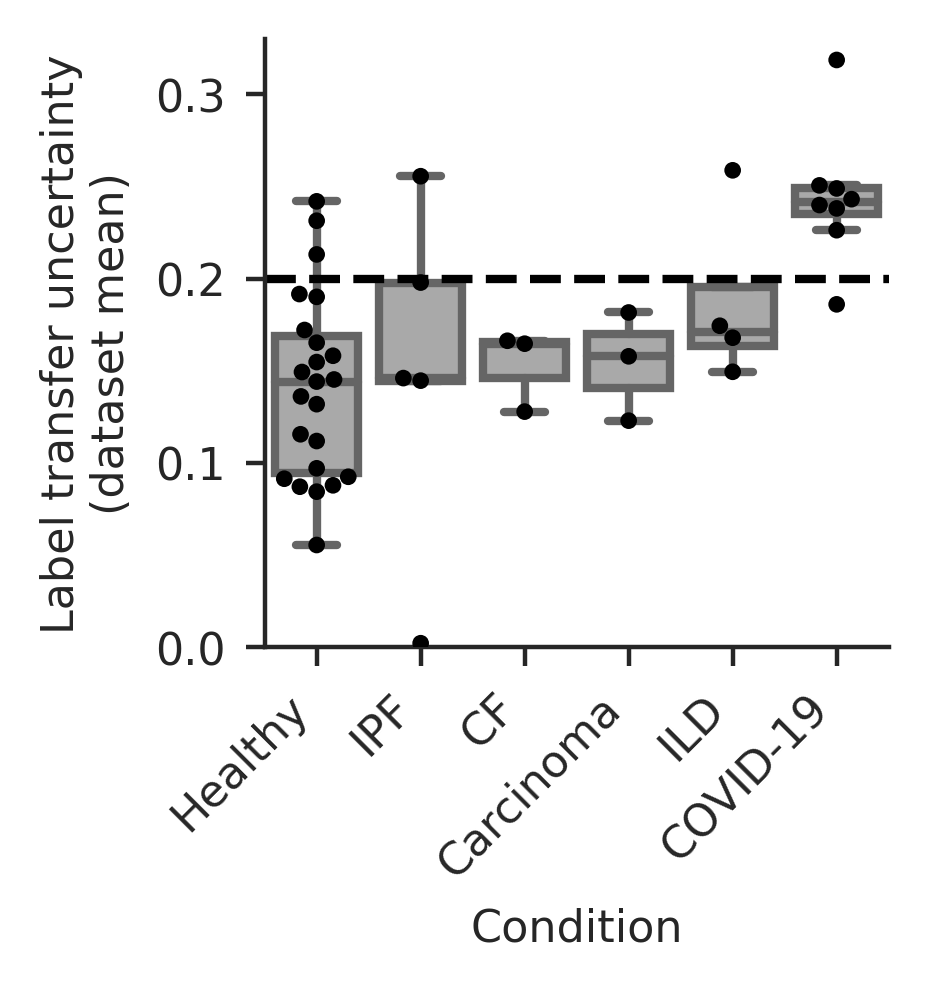

In [179]:
fz = 8
with plt.rc_context(
    {
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots(figsize=(2, 2))
    sns.boxplot(
        data=dataset_condition_info,
        x="condition",
        y="transf_ann_level_5_uncert",
        order=condition_order,
        color="darkgrey",
        ax=ax,
        fliersize=0,  # already included in swarmplot
    )
    sns.swarmplot(
        data=dataset_condition_info,
        x="condition",
        y="transf_ann_level_5_uncert",
        order=condition_order,
        color="black",
        ax=ax,
        size=3,
    )
    sns.despine()
    ax.axhline(unc_threshold, linestyle="dashed", color="black")
    ax.set(xlabel="Condition", ylabel="Label transfer uncertainty\n(dataset mean)")
    ax.set_ylim([0, 0.33])
    plt.xticks(rotation=45, horizontalalignment="right")
    plt.show()
    FIGURES["6b_uncertainty_by_condition"] = fig

In [180]:
dataset_cells_vs_nuclei_info = dataset_condition_info = (
    query_obs.groupby(["dataset", "cells_or_nuclei"])
    .agg(
        {
            "dataset": "first",
            "cells_or_nuclei": "first",
            "transf_ann_level_5_uncert": "mean",
        }
    )
    .dropna(axis=0, how="any")
).droplevel(level=1, axis=0)

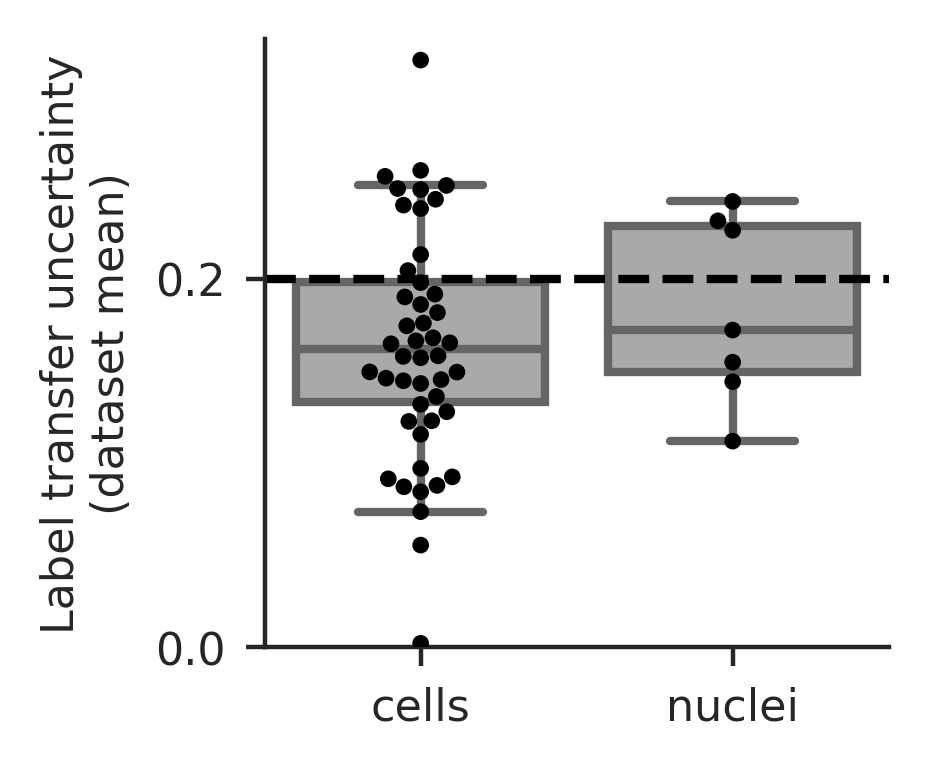

In [181]:
fz = 8
with plt.rc_context(
    {
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots(figsize=(2, 2))
    sns.boxplot(
        data=dataset_cells_vs_nuclei_info,
        x="cells_or_nuclei",
        y="transf_ann_level_5_uncert",
        color="darkgrey",
        ax=ax,
        fliersize=0,
    )
    sns.swarmplot(
        data=query_ds,
        x="cells_or_nuclei",
        y="transf_ann_level_5_uncert",
        color="black",
        ax=ax,
        size=3,
    )
    ax.axhline(unc_threshold, linestyle="dashed", color="black")
    ax.set(xlabel="", ylabel="Label transfer uncertainty\n(dataset mean)")
    ax.set_ylim([0, 0.33])
    sns.despine()
    FIGURES["6b_uncertainty_cells_vs_nuclei"] = fig

In [182]:
dataset_sample_type_info = (
    query_obs.groupby(["dataset", "sample_type", "tissue_disease_status"])
    .agg(
        {
            "sample_type": "first",
            "dataset": "first",
            "tissue_disease_status": "first",
            "transf_ann_level_5_uncert": "mean",
            "study": "first",
        }
    )
    .dropna(axis=0, how="any")
).droplevel(level=1, axis=0)
st_counts = dataset_sample_type_info.sample_type.value_counts()
sts_to_keep = st_counts[st_counts > 2].index.tolist()
dataset_sample_type_info = dataset_sample_type_info.loc[
    dataset_sample_type_info.sample_type.isin(sts_to_keep)
]
dataset_sample_type_info.sample_type = (
    dataset_sample_type_info.sample_type.cat.remove_unused_categories()
)
cond_counts = dataset_sample_type_info.tissue_disease_status.value_counts()
conds_to_keep = cond_counts[cond_counts > 2].index
dataset_sample_type_info = dataset_sample_type_info.loc[
    dataset_sample_type_info.tissue_disease_status.isin(conds_to_keep), :
].copy()
# check for sample type if every category has at least 2 studies, so that we are
# not including categories that we have multiple dataset but only from a single
# study for:
st_to_exclude = dataset_sample_type_info.groupby("sample_type").agg(
    {"study": "nunique"}
)
st_to_exclude = st_to_exclude.loc[st_to_exclude.study < 2].index.tolist()
st_cleaner = {
    "lung_explant": "Lung explant",
    "biopsy": "Biopsy",
    "autopsy": "Autopsy",
    "surgical_resection": "Surgical resection",
    "balf": "BALF",
    "donor_lung": "Donor lung",
    "donor_lung_cryopreserved": "Donor lung cryopreserved",
}
for st in st_cleaner.keys():
    if st in st_to_exclude:
        st_cleaner[st] = np.nan
for st in dataset_sample_type_info.sample_type.unique():
    if st not in st_cleaner.keys():
        raise ValueError(
            f"Missing sample type in your st_cleaner sample type mapper: {st}"
        )

dataset_sample_type_info[
    "Tissue sampling method"
] = dataset_sample_type_info.sample_type.map(st_cleaner)

In [183]:
st_counts

lung_explant                12
donor_lung                   8
surgical_resection           8
balf                         6
autopsy                      4
donor_lung_cryopreserved     4
brush                        2
scraping                     2
autopsy_cryopreserved        1
balf_cryopreserved           1
biopsy                       1
biopsy_cryopreserved         1
Name: sample_type, dtype: int64

In [184]:
st_order = list(
    dataset_sample_type_info.groupby("Tissue sampling method")
    .mean()
    .sort_values(by="transf_ann_level_5_uncert")
    .index
)

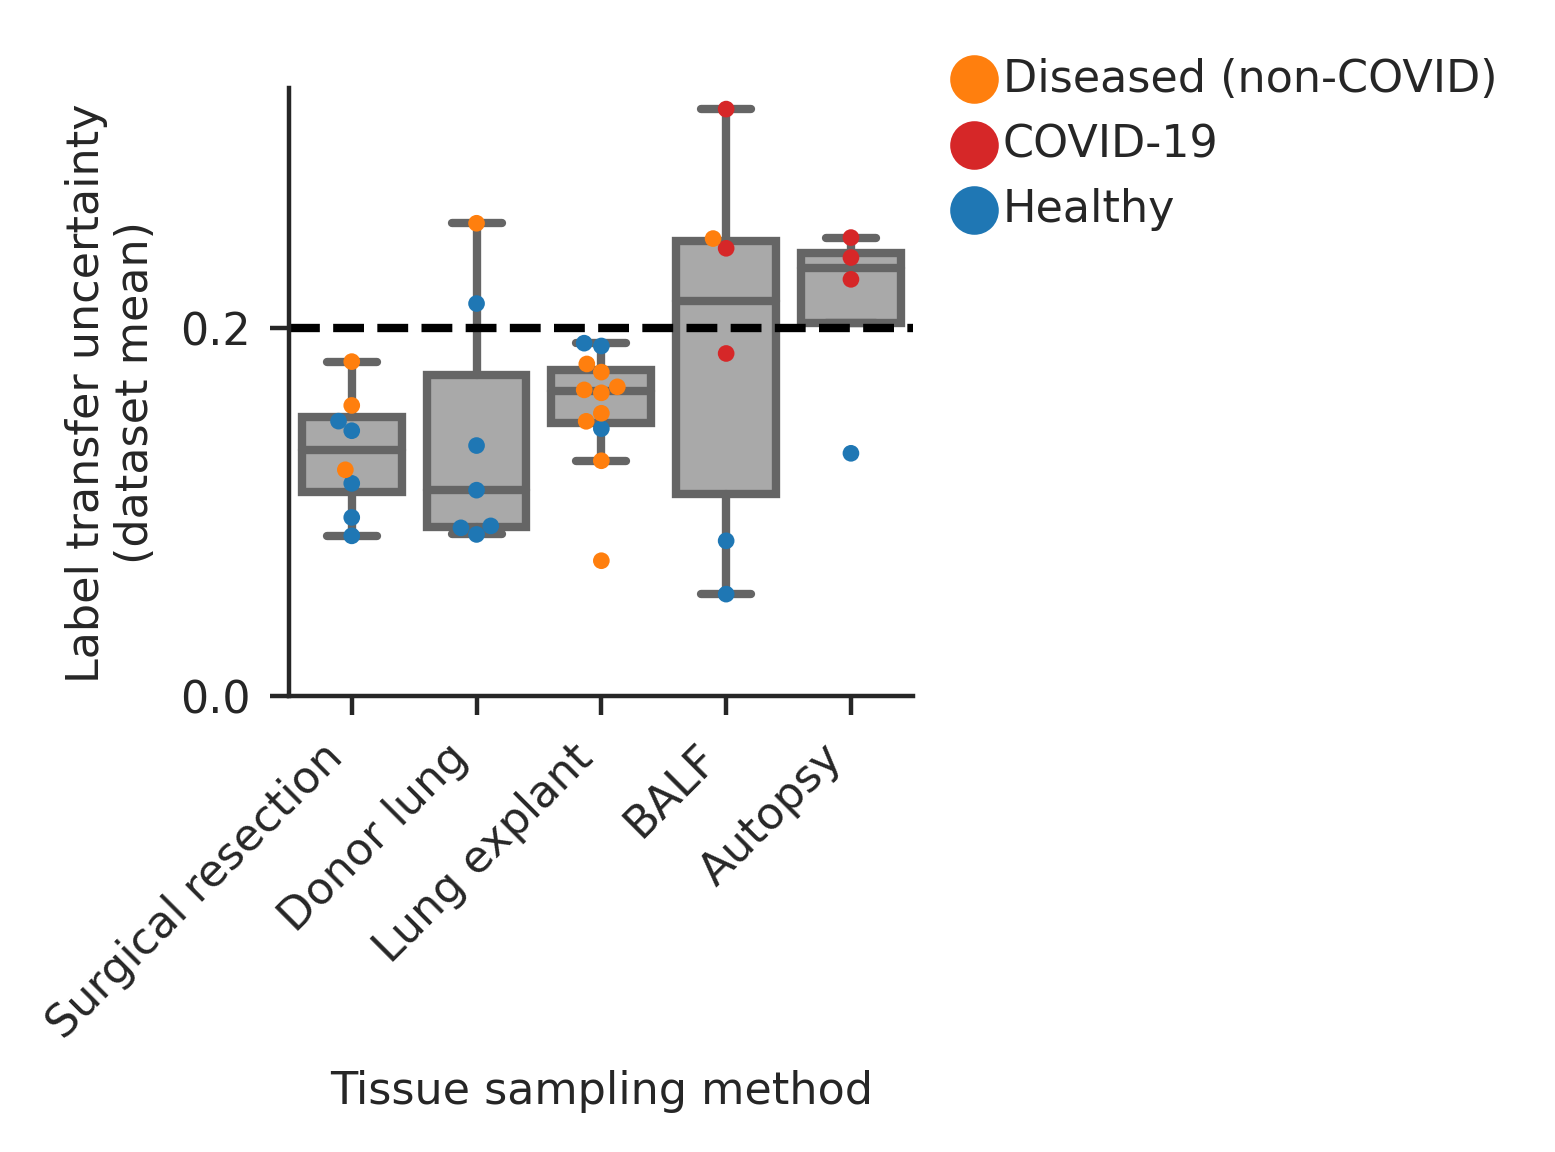

In [185]:
fz = 8
with plt.rc_context(
    {
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots(figsize=(2, 2))
    sns.boxplot(
        data=dataset_sample_type_info,
        x="Tissue sampling method",
        y="transf_ann_level_5_uncert",
        color="darkgrey",
        order=st_order,
        ax=ax,
        fliersize=0,
    )
    ax.axhline(unc_threshold, linestyle="dashed", color="black")
    sns.swarmplot(
        data=dataset_sample_type_info,
        x="Tissue sampling method",
        y="transf_ann_level_5_uncert",
        hue="tissue_disease_status",
        order=st_order,
        palette={
            "Healthy": "tab:blue",
            "Diseased (non-COVID)": "tab:orange",
            "COVID-19": "tab:red",
        },
        ax=ax,
        size=3,
    )
    ax.set(
        xlabel="Tissue sampling method",
        ylabel="Label transfer uncertainty\n(dataset mean)",
        ylim=0,
    )
    ax.legend(loc="lower right", bbox_to_anchor=(2, 0.7), frameon=False, fontsize=fz)
    ax.set_ylim([0, 0.33])
    plt.xticks(rotation=45, horizontalalignment="right")
    sns.despine()
    FIGURES["6b_uncertainty_by_sample_type"] = fig

In [186]:
dataset_platform_info = (
    query_obs.groupby(
        ["dataset", "single_cell_platform_short", "tissue_disease_status"]
    )
    .agg(
        {
            "single_cell_platform_short": "first",
            "dataset": "first",
            "tissue_disease_status": "first",
            "transf_ann_level_5_uncert": "mean",
        }
    )
    .dropna(axis=0, how="any")
).droplevel(level=1, axis=0)
platf_counts = dataset_platform_info.single_cell_platform_short.value_counts()
platf_to_keep = platf_counts[platf_counts > 2].index.tolist()
dataset_platform_info = dataset_platform_info.loc[
    dataset_platform_info.single_cell_platform_short.isin(platf_to_keep)
]
cond_counts = dataset_platform_info.tissue_disease_status.value_counts()
conds_to_keep = cond_counts[cond_counts > 2].index
dataset_platform_info = dataset_platform_info.loc[
    dataset_platform_info.tissue_disease_status.isin(conds_to_keep), :
].copy()

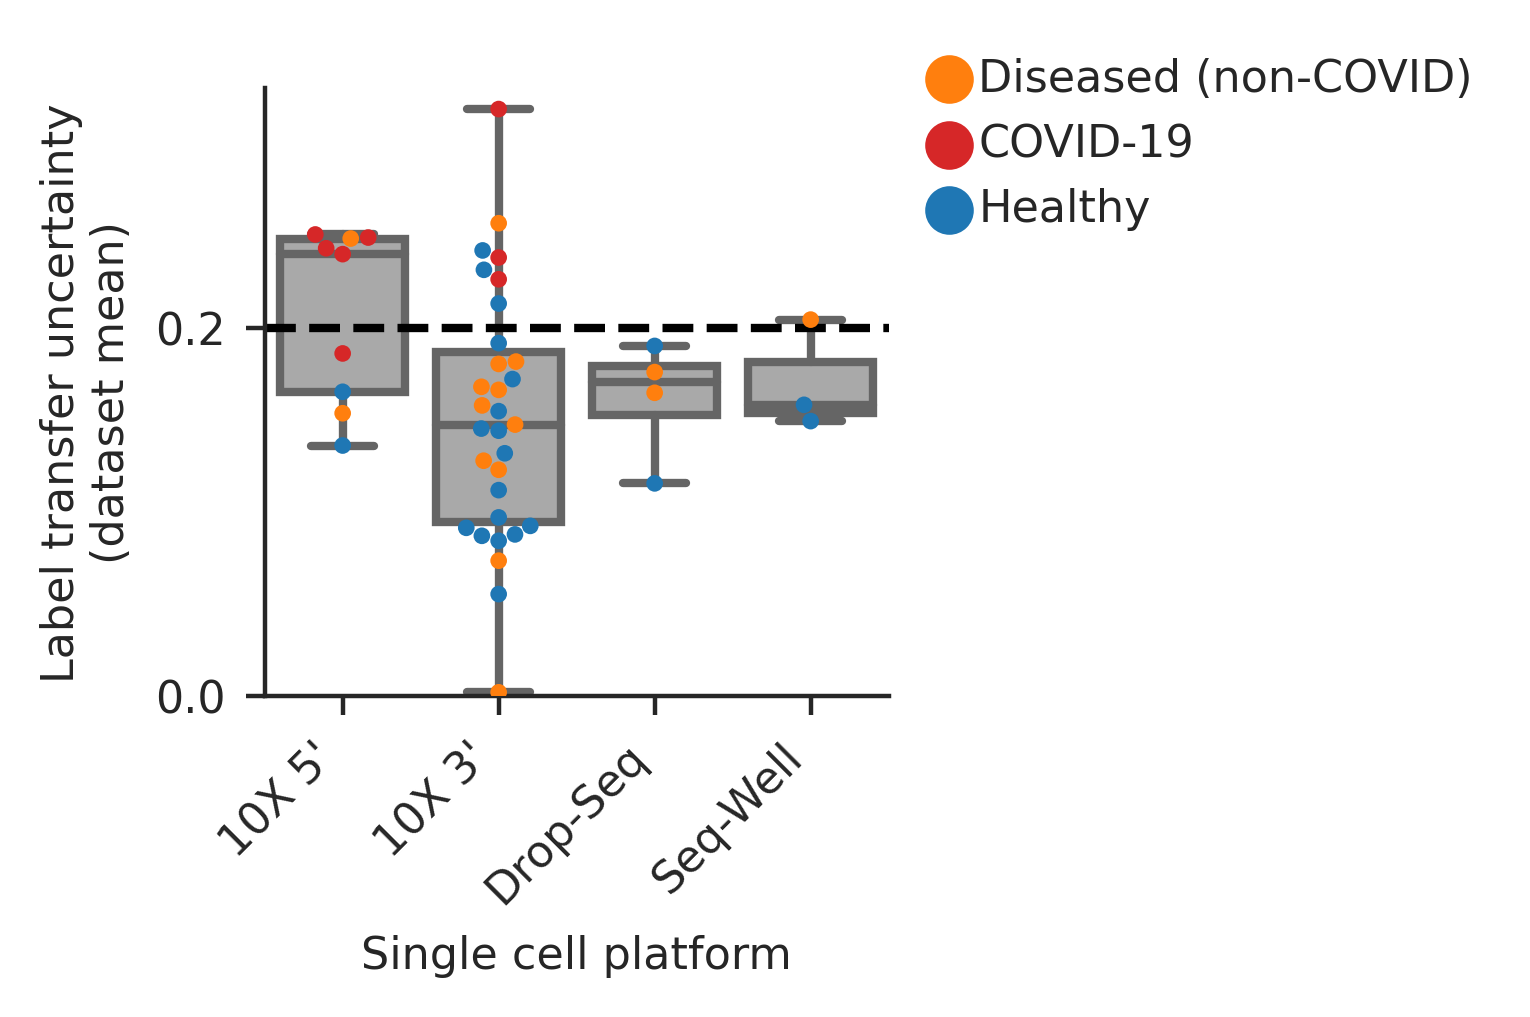

In [187]:
fz = 8
with plt.rc_context(
    {
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots(figsize=(2, 2))
    sns.boxplot(
        data=dataset_platform_info,
        x="single_cell_platform_short",
        y="transf_ann_level_5_uncert",
        color="darkgrey",
        # order=st_order,
        ax=ax,
        fliersize=0,
    )
    ax.axhline(unc_threshold, linestyle="dashed", color="black")
    sns.swarmplot(
        data=dataset_platform_info,
        x="single_cell_platform_short",
        y="transf_ann_level_5_uncert",
        hue="tissue_disease_status",
        # order=st_order,
        palette={
            "Healthy": "tab:blue",
            "Diseased (non-COVID)": "tab:orange",
            "COVID-19": "tab:red",
        },
        ax=ax,
        size=3,
    )
    ax.set(
        xlabel="Single cell platform",
        ylabel="Label transfer uncertainty\n(dataset mean)",
        ylim=0,
    )
    ax.legend(loc="lower right", bbox_to_anchor=(2, 0.7), frameon=False, fontsize=fz)
    ax.set_ylim([0, 0.33])
    plt.xticks(rotation=45, horizontalalignment="right")
    sns.despine()
    FIGURES["6b_uncertainty_by_single_cell_platform"] = fig

## Store figures:

In [188]:
for figname, fig in FIGURES.items():
    print("saving", figname)
    fig.savefig(
        os.path.join(dir_figures, f"{figname}.png"),
        bbox_inches="tight",
        dpi=140,
        transparent=True,
    )
    plt.close()

saving ED_ROC_curve_label_transfer
saving 6_label_tr_uncert_by_age
saving 6_label_tr_uncert_by_age_matched_core_barplot
saving ED_IPF_stroma_transfered_labs_and_uncert
saving ED_IPF_stroma_condition
saving ED_IPF_macro_transfered_labs_and_uncert
saving ED_IPF_macro_condition
saving ED_IPF_macro_SPP1_FABP4_expression
saving 6c_IPF_vs_Healthy_ct_uncerts
saving 6d_disease_score_alv_fibs_by_condition
saving 6d_disease_score_alv_macs_by_condition
saving 5b_uncertainty_by_condition
saving 5b_uncertainty_cells_vs_nuclei
saving 5b_uncertainty_by_sample_type
saving 5b_uncertainty_by_single_cell_platform


or save a single figure:

In [189]:
# figname = "6_label_tr_uncert_by_age_matched_core_barplot"
# fig = FIGURES[figname]
# fig.savefig(
#     os.path.join(dir_figures, f"{figname}.png"),
#     bbox_inches="tight",
#     dpi=140,
#     transparent=True,
# )

Store IPF gene DEAs and signatures:

In [190]:
fib_unc_degs_filt.to_csv(
    os.path.join(dir_IPF_uncertainty_analysis, "IPF_uncertainty_alv_fibro_dis_sign.csv")
)
macr_unc_degs_filt.to_csv(
    os.path.join(dir_IPF_uncertainty_analysis, "IPF_uncertainty_alv_macro_dis_sign.csv")
)
fib_unc_degs.to_csv(
    os.path.join(
        dir_IPF_uncertainty_analysis,
        "IPF_high_uncertainty_alv_fibro_diff_expr_analysis.csv",
    )
)
macr_unc_degs.to_csv(
    os.path.join(
        dir_IPF_uncertainty_analysis,
        "IPF_high_uncertainty_alv_macro_diff_expr_analysis.csv",
    )
)